In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [160]:
def clamp(A, minA, maxA):
        if minA > maxA:
            print("Localization::clamp: has improper bounds")
        if(A<minA):
            return minA
        if(A>maxA):
            return maxA
        return A
        
def clamp_angle(A):
    p2 = 2.0 * math.pi
    while A > p2:
        A -= p2
    
    while A < 0:
        A += p2
    return A

def angle_subtract(B,A):
    d = B-A
    p2 = 2.0 * math.pi
    if abs(d + p2) < abs(d):
        return d + p2
    if abs(d - p2) < abs(d):
        return d - p2
    return d

-1.5707963267948966

x_pos:  0.0 (m)
x_vel:  0.0 (m/s)
y_pos:  0.0 (m)
y_vel:  0.0 (m/s)
heading:  3.141592653589793 (rad)
heading_rate:  0.0 (rad/s)
forward speed:  0.0 (m/s)
forward acceleration:  0.0 (m/s^2)
forward jerk:  0.0 (m/s^3)
steering angle:  0.0 (rad)
steering angle rate:  0.0 (rad/s)
x_pos:  -9.753114480328735 (m)
x_vel:  -1.1485577192399796 (m/s)
y_pos:  5.784283361935748 (m)
y_vel:  0.7325963255620357 (m/s)
heading:  4.549105158924155 (rad)
heading_rate:  261.0391056967493 (rad/s)
forward speed:  1.7627581818082625 (m/s)
forward acceleration:  -1.163384098738473 (m/s^2)
forward jerk:  -2.5425272726942083 (m/s^3)
steering angle:  0.3293999999984936 (rad)
steering angle rate:  5.0213537032088124e-12 (rad/s)


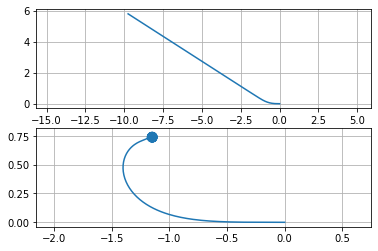

In [187]:
xi = 0 # x position
vxi = 1 # x velocity
yi = 2 # y postion
vyi = 3 # y velocity
hi = 4 # heading
vhi = 5 # heading rate
si = 6 # forward speed
vsi = 7 # forward acceleration
asi = 8 # forward jerk
ti = 9 # steering angle
vti = 10 # steering angle rate

class UnscentedKalmanFilter:
    s_ch = 20.0 # m/s - used for ground slip
    L = 1.0 # m - length from axle to axle
    T_speed = 0.3 # s - delay in speed commands
    T_steer = 0.3 # s - delay in steering commands
    max_steering_angle = 0.3294 # radians
    max_decel = -6.0 # m/s^2
    max_accel = 1.8 # m/s^2
    
    # state
    x = np.zeros([11,])
    x[hi] = math.pi
    
    def printState(self):
        print("x_pos: ", self.x[xi], "(m)")
        print("x_vel: ", self.x[vxi], "(m/s)")
        print("y_pos: ", self.x[yi], "(m)")
        print("y_vel: ", self.x[vyi], "(m/s)")
        print("heading: ", self.x[hi], "(rad)")
        print("heading_rate: ", self.x[vhi], "(rad/s)")
        print("forward speed: ", self.x[si], "(m/s)")
        print("forward acceleration: ", self.x[vsi], "(m/s^2)")
        print("forward jerk: ", self.x[asi], "(m/s^3)")
        print("steering angle: ", self.x[ti], "(rad)")
        print("steering angle rate: ", self.x[vti], "(rad/s)")
        
    def predict(self, x_in, accel_input, steer_input, dt):
        
        steer_input = clamp(steer_input, -self.max_steering_angle, self.max_steering_angle)
        
        cos_h = math.cos(x_in[hi])
        sin_h = math.sin(x_in[hi])
        
        # x position 
        x_in[xi] += x_in[vxi]*dt + 0.5*x_in[vsi]*cos_h*dt**2
        # x velocity
        x_in[vxi] += x_in[vsi]*cos_h*dt
        # y position
        x_in[yi] += x_in[vyi]*dt + 0.5*x_in[vsi]*sin_h*dt**2
        # y velocity
        x_in[vyi] += x_in[vsi]*sin_h*dt
        # heading
        x_in[hi] += x_in[vhi]*dt
        x_in[hi] = clamp_angle(x_in[hi])
        
        # Ground Slip
        gss = 1.0 / (1.0 + pow(x_in[si]/self.s_ch,2))
        
        # heading rate
        x_in[vhi] += (x_in[si]/self.L) * math.tan(x_in[ti]) * gss
        # forward speed
        x_in[si] += x_in[vsi]*dt + 0.5*x_in[asi]*dt**2
        # forward acceleraion
        x_in[vsi] += x_in[asi]*dt
        # clamp forward acceleration prediction
        x_in[vsi] = clamp(x_in[vsi], self.max_decel, self.max_accel)
        # forward jerk
        x_in[asi] = (1.0 / self.T_speed) * (accel_input - x_in[si])
        # steering angle
        x_in[ti] += x_in[vti]*dt
        x_in[ti] = clamp(x_in[ti], -self.max_steering_angle, self.max_steering_angle)
        # steering rate
        x_in[vti] = (1.0 / self.T_steer) * (steer_input - x_in[ti])
        
        return x_in
        

ukf = UnscentedKalmanFilter()
ukf.printState()
xs = []
steering_angle = 0.0
for i in range(900):
    steering_angle = steering_angle + 0.01*(angle_subtract(0.95*math.pi, ukf.x[hi]))
    ukf.x = ukf.predict(ukf.x, 1.0, steering_angle,0.01)
    #print("steering angle[", i, "]: ", steering_angle)
    #ukf.printState()
    xs.append(ukf.x.copy())

ukf.printState()

plt.subplot(2,1,1)
plt.plot(np.asarray(xs)[:,xi], np.asarray(xs)[:,yi])
plt.axis('equal')
plt.grid()
plt.subplot(2,1,2)
plt.plot(np.asarray(xs)[:,vxi], np.asarray(xs)[:,vyi])
plt.axis('equal')
plt.grid()

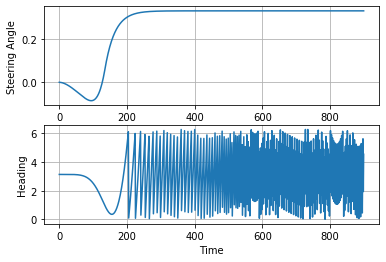

In [188]:
plt.subplot(2,1,1)
plt.plot(np.asarray(xs)[:,ti])
plt.ylabel("Steering Angle")
plt.grid()
plt.subplot(2,1,2)
plt.plot(np.asarray(xs)[:,hi])
plt.ylabel("Heading")
plt.xlabel("Time")
plt.grid()

In [55]:
class Localization:
    # assumes ENU local frame (x=East, y=North)
    # assumes WGS84 Spheroid for Global Frame (lat,lon in degrees)
    m_per_deg_lon = 8651.145668163364
    m_per_deg_lat = 111015.4870455103

    def __init__(self):
        print("Initializing Localization Engine")

    def update_m_per_deg(self, latMid):
        latMid = latMid * math.pi / 180.0
        self.m_per_deg_lat = 111132.92 - 559.82*math.cos(2*latMid) + 1.175*math.cos(4*latMid) - 0.002*math.cos(6*latMid)
        self.m_per_deg_lon = 111412.84*math.cos(latMid) - 93.5*math.cos(3*latMid) + 0.118*math.cos(5*latMid)
        print("Localization::update_m_per_deg: ",[self.m_per_deg_lon, self.m_per_deg_lat])

    def latLonToXY(self, dLat, dLon):
        # assumes ENU -> dLon -> x, dLat ->y
        # A = [39.510099961976394, -119.79924744019958]
        # B = [39.52450022763636, -119.83225271498078]
        # Dist = 3.26 km per Google and 3257.53m per this, call it Google rounding...
        dx = self.m_per_deg_lon * dLon
        dy = self.m_per_deg_lat * dLat
        return [dx,dy]
    
    def dist2d(self, dx, dy):
        return np.linalg.norm([dx,dy])
    
loc_engine = Localization()

loc_engine.update_m_per_deg(midLat)
[dx, dy] = loc_engine.latLonToXY(dLat, dLon)
dist = loc_engine.dist2d(dx,dy)
print("Dist: ", dist)

Initializing Localization Engine
Localization::update_m_per_deg:  [85992.06067989879, 111025.34429893654]
Dist:  3257.5259345151494


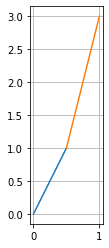

In [122]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot([a[0],b[0]],[a[1],b[1]])
#plt.plot([a[0],c[0]],[a[1],c[1]])
plt.plot([c[0],b[0]],[c[1],b[1]])

ax.set_aspect('equal')

plt.grid()

In [123]:
dt = 0.1

# displacement in global frame
d_ab = b - a
d_bc = c - b
print('displacement a->b: ', d_ab)
print('displacement b->c: ', d_bc)

# dists
l_ab = np.linalg.norm(a-b)
l_bc = np.linalg.norm(b-c)
print('distance a->b: ', l_ab)
print('distance b->c: ', l_bc)

# velocities in global frame
v_ab = d_ab / dt 
v_bc = d_bc / dt
print('velocity a->b: ', v_ab)
print('velocity b->c: ', v_bc)

# accelerations in global frame
a_abc = (v_bc - v_ab) / dt
a_mag = np.linalg.norm(a_abc)
print('acceleration ab->bc: ', a_abc, ' mag: ', a_mag)

displacement a->b:  [0.5 1. ]
displacement b->c:  [0.5 2. ]
distance a->b:  1.118033988749895
distance b->c:  2.0615528128088303
velocity a->b:  [ 5. 10.]
velocity b->c:  [ 5. 20.]
acceleration ab->bc:  [  0. 100.]  mag:  100.0


In [128]:
theta = math.atan2(d_ab[1],d_ab[0])
print('theta: ', 180*theta/3.14159)

gRl = np.array([[math.cos(theta), math.sin(theta)],[-math.sin(theta),math.cos(theta)]])

l_d_ab = gR1 * d_ab
l_d_ab

theta:  63.43500240417632


NameError: name 'gR1' is not defined

In [189]:
import numpy as np
import scipy.linalg
from copy import deepcopy
from threading import Lock
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
 
# started from - https://github.com/balghane/pyUKF
 
class UKFException(Exception):
    """Raise for errors in the UKF, usually due to bad inputs"""
 
 
class UKF:
    def __init__(self, num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function):
        """
        Initializes the unscented kalman filter
        :param num_states: int, the size of the state
        :param process_noise: the process noise covariance per unit time, should be num_states x num_states
        :param initial_state: initial values for the states, should be num_states x 1
        :param initial_covar: initial covariance matrix, should be num_states x num_states, typically large and diagonal
        :param alpha: UKF tuning parameter, determines spread of sigma points, typically a small positive value
        :param k: UKF tuning parameter, typically 0 or 3 - num_states
        :param beta: UKF tuning parameter, beta = 2 is ideal for gaussian distributions
        :param iterate_function: function that predicts the next state
                    takes in a num_states x 1 state and a float timestep
                    returns a num_states x 1 state
        """
        self.n_states = int(num_states)
        self.n_sigmas = 1 + num_states * 2
        self.q = process_noise
        self.x = initial_state
        self.p = initial_covar
        self.beta = beta
        self.alpha = alpha
        self.k = k
        self.iterate = iterate_function
 
        self.lambd = pow(self.alpha, 2) * (self.n_states + self.k) - self.n_states
 
        self.covar_weights = np.zeros(self.n_sigmas)
        self.mean_weights = np.zeros(self.n_sigmas)
 
        self.covar_weights[0] = (self.lambd / (self.n_states + self.lambd)) + (1 - pow(self.alpha, 2) + self.beta)
        self.mean_weights[0] = (self.lambd / (self.n_states + self.lambd))
 
        for i in range(1, self.n_sigmas):
            self.covar_weights[i] = 1 / (2*(self.n_states + self.lambd))
            self.mean_weights[i] = 1 / (2*(self.n_states + self.lambd))
 
        self.sigmas = self.__get_sigmas()
 
        self.lock = Lock()
 
    def __get_sigmas(self):
        """generates sigma points"""
        ret = np.zeros((self.n_sigmas, self.n_states))
 
        tmp_mat = (self.n_states + self.lambd)*self.p
 
        # print spr_mat
        spr_mat = scipy.linalg.sqrtm(tmp_mat)
 
        ret[0] = self.x
        for i in range(self.n_states):
            ret[i+1] = self.x + spr_mat[i]
            ret[i+1+self.n_states] = self.x - spr_mat[i]
 
        return ret.T
        
    def update(self, states, z_in, r_matrix):
        """
        performs a measurement update
        :param states: list of indices (zero-indexed) of which states were measured, that is, which are being updated
        :param data: list of the data corresponding to the values in states
        :param r_matrix: error matrix for the data, again corresponding to the values in states
        """
 
        self.lock.acquire()
 
        num_states = len(states)
 
        # create y, sigmas of just the states that are being updated
        sigmas_split = np.split(self.sigmas, self.n_states) # split sigmas into n_states 1d array
        z_sigmas = np.concatenate([sigmas_split[i] for i in states]) # get sigmas in one array for desired states
 
 
        # create z_mean, the mean of just the states that are being updated
        x_split = np.split(self.x, self.n_states) # splits x into n_states 1d arrays
        z_mean = np.concatenate([x_split[i] for i in states]) # assembles y mean into one array using x split desired states
 
        z_diff = deepcopy(z_sigmas) # differences in z_sigmas from z mean for getting covariances
        x_diff = deepcopy(self.sigmas) # differences in sigmas from x for getting covariances
        for i in range(self.n_sigmas):
            for j in range(num_states):
                z_diff[j][i] -= z_mean[j]
            for j in range(self.n_states):
                x_diff[j][i] -= self.x[j]
 
        # covariance of measurement
        p_zz = np.zeros((num_states, num_states))
        for i, val in enumerate(np.array_split(z_diff, self.n_sigmas, 1)):
            p_zz += self.covar_weights[i] * val.dot(val.T)
 
        # add measurement noise
        p_zz += r_matrix
 
        # cross covariance of measurement with states
        p_xz = np.zeros((self.n_states, num_states))
        for i, val in enumerate(zip(np.array_split(z_diff, self.n_sigmas, 1), np.array_split(x_diff, self.n_sigmas, 1))):
            print('val[1]: ', val[1])
            print('val[0].T: ', val[0].T)
            print('val[1].dot(val[0].T): ', val[1].dot(val[0].T))
            
            
            p_xz += self.covar_weights[i] * val[1].dot(val[0].T)
 
        # set the kalman gain
        k = np.dot(p_xz, np.linalg.inv(p_zz))
 
        # update the state using the kalman gain and error
        z_actual = z_in
        self.x += np.dot(k, (z_actual - z_mean))
 
        # update the covariance with kalman gain
        self.p -= np.dot(k, np.dot(p_zz, k.T))
 
        # reset sigmas
        self.sigmas = self.__get_sigmas()
 
        self.lock.release()
 
    def update_bearing(self, states, r_matrix, target, z_in):
        """
        performs a measurement update
        :param states: list of indices (zero-indexed) of which states were measured, that is, which are being updated
        :param data: list of the data corresponding to the values in states
        :param r_matrix: error matrix for the data, again corresponding to the values in states
        """
 
        self.lock.acquire()
 
        num_states = len(states)
        num_measure = 1
 
        # create y, sigmas of just the states that are being updated
        sigmas_split = np.split(self.sigmas, self.n_states) # split sigmas into n_states 1d array
        z_sigmas = np.concatenate([sigmas_split[i] for i in states]) # get sigmas in one array for desired states
        z_measure = np.zeros((self.n_sigmas, num_measure))
        for i in range(self.n_sigmas):
            z_measure[i] = math.atan2(z_sigmas[1,i] - target[1], z_sigmas[0,i] - target[0])
        
 
        # create z_mean, the mean of just the states that are being updated
        x_split = np.split(self.x, self.n_states) # splits x into n_states 1d arrays
        z_mean = 0.0 # assembles y mean into one array using x split desired states
        for i in range(self.n_sigmas):
          z_mean += self.mean_weights[i] * z_measure[i]
 
        # get differences
        x_diff = deepcopy(self.sigmas) # differences in sigmas from x for getting covariances
        for i in range(self.n_sigmas):
            for j in range(self.n_states):
                x_diff[j][i] -= self.x[j]
        
        z_diff = deepcopy(z_measure) # differences in z_sigmas from z mean for getting covariances
        for i in range(self.n_sigmas):
            z_diff[i][0] -= z_mean
 
        # covariance of measurement
        p_zz = np.zeros((num_measure, num_measure))
        for i, val in enumerate(z_diff):
            # print("val: ", val)
            # temp = val.T.dot(val)
            # print("val.dot(val.T): ", val.dot(val.T))
            # print("covar_weights[i]: ", self.covar_weights[i])
            # print("self.covar_weights[i] * val.dot(val.T): ", self.covar_weights[i] * val.dot(val.T))
            p_zz += self.covar_weights[i] * val.dot(val.T)
 
        # add measurement noise
        p_zz += r_matrix
 
        # cross covariance of measurement with states
        p_xz = np.zeros((self.n_states, num_measure))
        for i, val in enumerate(zip(np.array_split(z_diff, self.n_sigmas), np.array_split(x_diff, self.n_sigmas, 1))):
            p_xz += self.covar_weights[i] * val[1].dot(val[0].T)
 
        # set the kalman gain
        k = np.dot(p_xz, np.linalg.inv(p_zz))
 
        # update the state using the kalman gain and error
        z_actual = z_in
        self.x += np.dot(k, (z_actual - z_mean))
 
        # update the covariance with kalman gain
        self.p -= np.dot(k, np.dot(p_zz, k.T))
 
        # reset sigmas
        self.sigmas = self.__get_sigmas()
 
        self.lock.release()
 
    def update_range(self, states, r_matrix, target, z_in):
        """
        performs a measurement update
        :param states: list of indices (zero-indexed) of which states were measured, that is, which are being updated
        :param data: list of the data corresponding to the values in states
        :param r_matrix: error matrix for the data, again corresponding to the values in states
        """
 
        self.lock.acquire()
 
        num_states = len(states)
        num_measure = 1
 
        # create y, sigmas of just the states that are being updated
        sigmas_split = np.split(self.sigmas, self.n_states) # split sigmas into n_states 1d array
        z_sigmas = np.concatenate([sigmas_split[i] for i in states]) # get sigmas in one array for desired states
        z_measure = np.zeros((self.n_sigmas, num_measure))
        for i in range(self.n_sigmas):
            z_measure[i] = np.linalg.norm(z_sigmas[:,i] - target)
        
 
        # create z_mean, the mean of just the states that are being updated
        x_split = np.split(self.x, self.n_states) # splits x into n_states 1d arrays
        z_mean = 0.0 # assembles y mean into one array using x split desired states
        for i in range(self.n_sigmas):
          z_mean += self.mean_weights[i] * z_measure[i]
 
        # get differences
        x_diff = deepcopy(self.sigmas) # differences in sigmas from x for getting covariances
        for i in range(self.n_sigmas):
            for j in range(self.n_states):
                x_diff[j][i] -= self.x[j]
        
        z_diff = deepcopy(z_measure) # differences in z_sigmas from z mean for getting covariances
        for i in range(self.n_sigmas):
            z_diff[i][0] -= z_mean
 
        # covariance of measurement
        p_zz = np.zeros((num_measure, num_measure))
        for i, val in enumerate(z_diff):
            # print("val: ", val)
            # temp = val.T.dot(val)
            # print("val.dot(val.T): ", val.dot(val.T))
            # print("covar_weights[i]: ", self.covar_weights[i])
            # print("self.covar_weights[i] * val.dot(val.T): ", self.covar_weights[i] * val.dot(val.T))
            p_zz += self.covar_weights[i] * val.dot(val.T)
 
        # add measurement noise
        p_zz += r_matrix
 
       # cross covariance of measurement with states
        p_xz = np.zeros((self.n_states, num_measure))
        for i, val in enumerate(zip(np.array_split(z_diff, self.n_sigmas), np.array_split(x_diff, self.n_sigmas, 1))):
            p_xz += self.covar_weights[i] * val[1].dot(val[0].T)
 
        # set the kalman gain
        k = np.dot(p_xz, np.linalg.inv(p_zz))
 
        # update the state using the kalman gain and error
        z_actual = z_in
        self.x += np.dot(k, (z_actual - z_mean))
 
        # update the covariance with kalman gain
        self.p -= np.dot(k, np.dot(p_zz, k.T))
 
        # reset sigmas
        self.sigmas = self.__get_sigmas()
 
        self.lock.release()
 
    def predict(self, timestep, inputs=[]):
        """
        performs a prediction step
        :param timestep: float, amount of time since last prediction
        """
 
        self.lock.acquire()
 
        #print("sigmas prior: ", self.sigmas)
        sigmas_out = np.array([self.iterate(x, timestep, inputs) for x in self.sigmas.T]).T
        print("sigmas out: ", sigmas_out)
 
        x_out = np.zeros(self.n_states)
 
        # for each variable in X
        for i in range(self.n_states):
            # the mean of that variable is the sum of
            # the weighted values of that variable for each iterated sigma point
            x_out[i] = sum((self.mean_weights[j] * sigmas_out[i][j] for j in range(self.n_sigmas)))
 
        p_out = np.zeros((self.n_states, self.n_states))
        # for each sigma point
        for i in range(self.n_sigmas):
            # take the distance from the mean
            # make it a covariance by multiplying by the transpose
            # weight it using the calculated weighting factor
            # and sum
            diff = sigmas_out.T[i] - x_out
            diff = np.atleast_2d(diff)
            diff_dot = np.dot(diff.T, diff)
            p_out += self.covar_weights[i] * diff_dot
 
        # add process noise
        p_out += timestep * self.q
 
        self.sigmas = sigmas_out
        self.x = x_out
        self.p = p_out
 
        self.lock.release()
 
    def get_state(self, index=-1):
        """
        returns the current state (n_states x 1), or a particular state variable (float)
        :param index: optional, if provided, the index of the returned variable
        :return:
        """
        if index >= 0:
            return self.x[index]
        else:
            return self.x
 
    def get_covar(self):
        """
        :return: current state covariance (n_states x n_states)
        """
        return self.p
 
    def set_state(self, value, index=-1):
        """
        Overrides the filter by setting one variable of the state or the whole state
        :param value: the value to put into the state (1 x 1 or n_states x 1)
        :param index: the index at which to override the state (-1 for whole state)
        """
        with self.lock:
            if index != -1:
                self.x[index] = value
            else:
                self.x = value
                
    def set_covar(self, p_in):
        """ ANDY FUNCTION
        : Override the filter by setting the covariance
        """
        self.p = deepcopy(p_in)
    
 
    def reset(self, state, covar):
        """
        Restarts the UKF at the given state and covariance
        :param state: n_states x 1
        :param covar: n_states x n_states
        """
 
        with self.lock:
            self.x = state
            self.p = covar


sigmas out:  [[ 0.1    0.353  0.1    0.103  0.1   -0.153  0.1    0.097  0.1  ]
 [20.    20.    20.253 20.    20.003 20.    19.747 20.    19.997]
 [ 1.     1.     1.     1.025  1.     1.     1.     0.975  1.   ]
 [ 0.     0.     0.     0.     0.025  0.     0.     0.    -0.025]]
val[1]:  [[-5.274e-16]
 [-1.137e-12]
 [ 1.421e-14]
 [ 0.000e+00]]
val[0].T:  [[-5.274e-16 -1.137e-12]]
val[1].dot(val[0].T):  [[ 2.781e-31  5.995e-28]
 [ 5.995e-28  1.292e-24]
 [-7.494e-30 -1.616e-26]
 [ 0.000e+00  0.000e+00]]
val[1]:  [[ 2.530e-01]
 [-1.137e-12]
 [ 1.421e-14]
 [ 0.000e+00]]
val[0].T:  [[ 2.530e-01 -1.137e-12]]
val[1].dot(val[0].T):  [[ 6.400e-02 -2.876e-13]
 [-2.876e-13  1.292e-24]
 [ 3.595e-15 -1.616e-26]
 [ 0.000e+00  0.000e+00]]
val[1]:  [[-5.274e-16]
 [ 2.530e-01]
 [ 1.421e-14]
 [ 0.000e+00]]
val[0].T:  [[-5.274e-16  2.530e-01]]
val[1].dot(val[0].T):  [[ 2.781e-31 -1.334e-16]
 [-1.334e-16  6.400e-02]
 [-7.494e-30  3.595e-15]
 [ 0.000e+00  0.000e+00]]
val[1]:  [[ 2.530e-03]
 [-1.137e-12]
 [ 2

val[0].T:  [[ 7.764e-03 -6.384e-16]]
val[1].dot(val[0].T):  [[ 1.021e-05 -8.391e-19]
 [ 1.203e-14 -9.888e-28]
 [ 6.028e-05 -4.956e-18]
 [-4.956e-18  4.075e-31]]
val[1]:  [[9.104e-15]
 [1.315e-03]
 [2.209e-14]
 [7.764e-03]]
val[0].T:  [[2.209e-14 7.764e-03]]
val[1].dot(val[0].T):  [[2.011e-28 7.068e-17]
 [2.904e-17 1.021e-05]
 [4.881e-28 1.715e-16]
 [1.715e-16 6.028e-05]]
val[1]:  [[-1.403e-02]
 [ 1.549e-12]
 [-5.381e-04]
 [-6.384e-16]]
val[0].T:  [[-5.381e-04 -6.384e-16]]
val[1].dot(val[0].T):  [[ 7.551e-06  8.958e-18]
 [-8.335e-16 -9.888e-28]
 [ 2.896e-07  3.435e-19]
 [ 3.435e-19  4.075e-31]]
val[1]:  [[ 9.104e-15]
 [-1.403e-02]
 [ 2.209e-14]
 [-5.381e-04]]
val[0].T:  [[ 2.209e-14 -5.381e-04]]
val[1].dot(val[0].T):  [[ 2.011e-28 -4.899e-18]
 [-3.100e-16  7.551e-06]
 [ 4.881e-28 -1.189e-17]
 [-1.189e-17  2.896e-07]]
val[1]:  [[-1.315e-03]
 [ 1.549e-12]
 [-7.764e-03]
 [-6.384e-16]]
val[0].T:  [[-7.764e-03 -6.384e-16]]
val[1].dot(val[0].T):  [[ 1.021e-05  8.391e-19]
 [-1.203e-14 -9.888e-

 [-9.948e-17  2.090e-05]]
val[1]:  [[-1.492e-02]
 [ 3.013e-12]
 [-9.126e-04]
 [ 1.192e-15]]
val[0].T:  [[-9.126e-04  1.192e-15]]
val[1].dot(val[0].T):  [[ 1.361e-05 -1.778e-17]
 [-2.749e-15  3.590e-27]
 [ 8.328e-07 -1.088e-18]
 [-1.088e-18  1.420e-30]]
val[1]:  [[ 2.931e-14]
 [-1.492e-02]
 [-2.176e-14]
 [-9.126e-04]]
val[0].T:  [[-2.176e-14 -9.126e-04]]
val[1].dot(val[0].T):  [[-6.378e-28 -2.675e-17]
 [ 3.246e-16  1.361e-05]
 [ 4.735e-28  1.986e-17]
 [ 1.986e-17  8.328e-07]]
val[1]:  [[-1.370e-03]
 [ 3.013e-12]
 [-4.572e-03]
 [ 1.192e-15]]
val[0].T:  [[-4.572e-03  1.192e-15]]
val[1].dot(val[0].T):  [[ 6.262e-06 -1.632e-18]
 [-1.377e-14  3.590e-27]
 [ 2.090e-05 -5.448e-18]
 [-5.448e-18  1.420e-30]]
val[1]:  [[ 2.931e-14]
 [-1.370e-03]
 [-2.176e-14]
 [-4.572e-03]]
val[0].T:  [[-2.176e-14 -4.572e-03]]
val[1].dot(val[0].T):  [[-6.378e-28 -1.340e-16]
 [ 2.981e-17  6.262e-06]
 [ 4.735e-28  9.948e-17]
 [ 9.948e-17  2.090e-05]]
sigmas out:  [[1.261e+00 1.276e+00 1.261e+00 1.262e+00 1.261e+00 1

val[0].T:  [[-1.094e-13 -9.359e-04]]
val[1].dot(val[0].T):  [[-1.117e-26 -9.560e-17]
 [ 1.732e-15  1.482e-05]
 [ 1.196e-26  1.024e-16]
 [ 1.024e-16  8.760e-07]]
val[1]:  [[-1.359e-03]
 [ 2.199e-12]
 [-4.230e-03]
 [ 2.604e-16]]
val[0].T:  [[-4.230e-03  2.604e-16]]
val[1].dot(val[0].T):  [[ 5.748e-06 -3.539e-19]
 [-9.301e-15  5.727e-28]
 [ 1.789e-05 -1.101e-18]
 [-1.101e-18  6.782e-32]]
val[1]:  [[ 1.021e-13]
 [-1.359e-03]
 [-1.094e-13]
 [-4.230e-03]]
val[0].T:  [[-1.094e-13 -4.230e-03]]
val[1].dot(val[0].T):  [[-1.117e-26 -4.320e-16]
 [ 1.486e-16  5.748e-06]
 [ 1.196e-26  4.625e-16]
 [ 4.625e-16  1.789e-05]]
sigmas out:  [[ 2.347e+00  2.363e+00  2.347e+00  2.349e+00  2.347e+00  2.332e+00
   2.347e+00  2.346e+00  2.347e+00]
 [ 2.035e+01  2.035e+01  2.037e+01  2.035e+01  2.035e+01  2.035e+01
   2.034e+01  2.035e+01  2.035e+01]
 [ 9.896e-01  9.906e-01  9.896e-01  9.939e-01  9.896e-01  9.887e-01
   9.896e-01  9.854e-01  9.896e-01]
 [-4.625e-03 -4.625e-03 -3.690e-03 -4.625e-03 -4.035e-04 -4.

sigmas out:  [[ 2.848e+00  2.864e+00  2.848e+00  2.849e+00  2.848e+00  2.831e+00
   2.848e+00  2.846e+00  2.848e+00]
 [ 2.035e+01  2.035e+01  2.036e+01  2.035e+01  2.035e+01  2.035e+01
   2.033e+01  2.035e+01  2.035e+01]
 [ 9.938e-01  9.947e-01  9.938e-01  9.980e-01  9.938e-01  9.928e-01
   9.938e-01  9.896e-01  9.938e-01]
 [-6.329e-03 -6.329e-03 -5.403e-03 -6.329e-03 -2.131e-03 -6.329e-03
  -7.255e-03 -6.329e-03 -1.053e-02]]
val[1]:  [[ 7.949e-14]
 [-8.598e-13]
 [-1.787e-14]
 [-6.861e-16]]
val[0].T:  [[-1.787e-14 -6.861e-16]]
val[1].dot(val[0].T):  [[-1.421e-27 -5.454e-29]
 [ 1.537e-26  5.899e-28]
 [ 3.195e-28  1.226e-29]
 [ 1.226e-29  4.707e-31]]
val[1]:  [[ 1.632e-02]
 [-8.598e-13]
 [ 9.259e-04]
 [-6.861e-16]]
val[0].T:  [[ 9.259e-04 -6.861e-16]]
val[1].dot(val[0].T):  [[ 1.511e-05 -1.119e-17]
 [-7.960e-16  5.899e-28]
 [ 8.573e-07 -6.352e-19]
 [-6.352e-19  4.707e-31]]
val[1]:  [[ 7.949e-14]
 [ 1.632e-02]
 [-1.787e-14]
 [ 9.259e-04]]
val[0].T:  [[-1.787e-14  9.259e-04]]
val[1].dot(va

val[1].dot(val[0].T):  [[ 1.532e-05  7.282e-18]
 [-1.130e-15 -5.371e-28]
 [ 8.259e-07  3.926e-19]
 [ 3.926e-19  1.866e-31]]
val[1]:  [[-8.793e-14]
 [-1.686e-02]
 [ 1.199e-14]
 [-9.088e-04]]
val[0].T:  [[ 1.199e-14 -9.088e-04]]
val[1].dot(val[0].T):  [[-1.054e-27  7.991e-17]
 [-2.021e-16  1.532e-05]
 [ 1.438e-28 -1.090e-17]
 [-1.090e-17  8.259e-07]]
val[1]:  [[-1.328e-03]
 [ 1.243e-12]
 [-4.190e-03]
 [-4.319e-16]]
val[0].T:  [[-4.190e-03 -4.319e-16]]
val[1].dot(val[0].T):  [[ 5.564e-06  5.735e-19]
 [-5.210e-15 -5.371e-28]
 [ 1.756e-05  1.810e-18]
 [ 1.810e-18  1.866e-31]]
val[1]:  [[-8.793e-14]
 [-1.328e-03]
 [ 1.199e-14]
 [-4.190e-03]]
val[0].T:  [[ 1.199e-14 -4.190e-03]]
val[1].dot(val[0].T):  [[-1.054e-27  3.684e-16]
 [-1.592e-17  5.564e-06]
 [ 1.438e-28 -5.024e-17]
 [-5.024e-17  1.756e-05]]
sigmas out:  [[ 3.646e+00  3.663e+00  3.646e+00  3.647e+00  3.646e+00  3.629e+00
   3.646e+00  3.645e+00  3.646e+00]
 [ 2.035e+01  2.035e+01  2.036e+01  2.035e+01  2.035e+01  2.035e+01
   2.033e+

sigmas out:  [[ 4.550e+00  4.568e+00  4.550e+00  4.552e+00  4.550e+00  4.533e+00
   4.550e+00  4.549e+00  4.550e+00]
 [ 2.034e+01  2.034e+01  2.036e+01  2.034e+01  2.035e+01  2.034e+01
   2.033e+01  2.034e+01  2.034e+01]
 [ 9.998e-01  1.001e+00  9.998e-01  1.004e+00  9.998e-01  9.989e-01
   9.998e-01  9.956e-01  9.998e-01]
 [-1.179e-03 -1.179e-03 -2.972e-04 -1.179e-03  3.013e-03 -1.179e-03
  -2.060e-03 -1.179e-03 -5.371e-03]]
val[1]:  [[-8.527e-14]
 [-1.290e-12]
 [ 5.096e-14]
 [ 8.066e-17]]
val[0].T:  [[5.096e-14 8.066e-17]]
val[1].dot(val[0].T):  [[-4.345e-27 -6.878e-30]
 [-6.572e-26 -1.040e-28]
 [ 2.597e-27  4.111e-30]
 [ 4.111e-30  6.507e-33]]
val[1]:  [[ 1.760e-02]
 [-1.290e-12]
 [ 8.816e-04]
 [ 8.066e-17]]
val[0].T:  [[8.816e-04 8.066e-17]]
val[1].dot(val[0].T):  [[ 1.552e-05  1.420e-18]
 [-1.137e-15 -1.040e-28]
 [ 7.773e-07  7.112e-20]
 [ 7.112e-20  6.507e-33]]
val[1]:  [[-8.527e-14]
 [ 1.760e-02]
 [ 5.096e-14]
 [ 8.816e-04]]
val[0].T:  [[5.096e-14 8.816e-04]]
val[1].dot(val[0].T

val[1].dot(val[0].T):  [[-1.479e-27 -5.701e-16]
 [ 1.398e-17  5.390e-06]
 [ 1.184e-28  4.564e-17]
 [ 4.564e-17  1.760e-05]]
val[1]:  [[-1.804e-02]
 [-5.116e-13]
 [-8.654e-04]
 [-2.958e-16]]
val[0].T:  [[-8.654e-04 -2.958e-16]]
val[1].dot(val[0].T):  [[1.561e-05 5.335e-18]
 [4.427e-16 1.513e-28]
 [7.489e-07 2.560e-19]
 [2.560e-19 8.748e-32]]
val[1]:  [[-1.359e-13]
 [-1.804e-02]
 [ 1.088e-14]
 [-8.654e-04]]
val[0].T:  [[ 1.088e-14 -8.654e-04]]
val[1].dot(val[0].T):  [[-1.479e-27  1.176e-16]
 [-1.962e-16  1.561e-05]
 [ 1.184e-28 -9.416e-18]
 [-9.416e-18  7.489e-07]]
val[1]:  [[-1.285e-03]
 [-5.116e-13]
 [-4.195e-03]
 [-2.958e-16]]
val[0].T:  [[-4.195e-03 -2.958e-16]]
val[1].dot(val[0].T):  [[5.390e-06 3.800e-19]
 [2.146e-15 1.513e-28]
 [1.760e-05 1.241e-18]
 [1.241e-18 8.748e-32]]
val[1]:  [[-1.359e-13]
 [-1.285e-03]
 [ 1.088e-14]
 [-4.195e-03]]
val[0].T:  [[ 1.088e-14 -4.195e-03]]
val[1].dot(val[0].T):  [[-1.479e-27  5.701e-16]
 [-1.398e-17  5.390e-06]
 [ 1.184e-28 -4.564e-17]
 [-4.564e-

 [-4.718e-16]]
val[0].T:  [[ 8.837e-14 -4.718e-16]]
val[1].dot(val[0].T):  [[ 3.846e-26 -2.054e-28]
 [ 1.127e-25 -6.018e-28]
 [ 7.810e-27 -4.170e-29]
 [-4.170e-29  2.226e-31]]
val[1]:  [[ 1.860e-02]
 [ 1.275e-12]
 [ 8.446e-04]
 [-4.718e-16]]
val[0].T:  [[ 8.446e-04 -4.718e-16]]
val[1].dot(val[0].T):  [[ 1.571e-05 -8.775e-18]
 [ 1.077e-15 -6.018e-28]
 [ 7.134e-07 -3.985e-19]
 [-3.985e-19  2.226e-31]]
val[1]:  [[4.352e-13]
 [1.860e-02]
 [8.837e-14]
 [8.446e-04]]
val[0].T:  [[8.837e-14 8.446e-04]]
val[1].dot(val[0].T):  [[3.846e-26 3.676e-16]
 [1.644e-15 1.571e-05]
 [7.810e-27 7.464e-17]
 [7.464e-17 7.134e-07]]
val[1]:  [[ 1.265e-03]
 [ 1.275e-12]
 [ 4.199e-03]
 [-4.718e-16]]
val[0].T:  [[ 4.199e-03 -4.718e-16]]
val[1].dot(val[0].T):  [[ 5.310e-06 -5.967e-19]
 [ 5.356e-15 -6.018e-28]
 [ 1.763e-05 -1.981e-18]
 [-1.981e-18  2.226e-31]]
val[1]:  [[4.352e-13]
 [1.265e-03]
 [8.837e-14]
 [4.199e-03]]
val[0].T:  [[8.837e-14 4.199e-03]]
val[1].dot(val[0].T):  [[3.846e-26 1.827e-15]
 [1.118e-16 5.

val[1].dot(val[0].T):  [[-6.358e-27 -7.569e-17]
 [ 1.326e-15  1.578e-05]
 [ 4.830e-27  5.751e-17]
 [ 5.751e-17  6.846e-07]]
val[1]:  [[-1.248e-03]
 [-1.229e-12]
 [-4.202e-03]
 [ 8.674e-18]]
val[0].T:  [[-4.202e-03  8.674e-18]]
val[1].dot(val[0].T):  [[ 5.243e-06 -1.082e-20]
 [ 5.166e-15 -1.066e-29]
 [ 1.766e-05 -3.645e-20]
 [-3.645e-20  7.523e-35]]
val[1]:  [[ 9.148e-14]
 [-1.248e-03]
 [-6.950e-14]
 [-4.202e-03]]
val[0].T:  [[-6.950e-14 -4.202e-03]]
val[1].dot(val[0].T):  [[-6.358e-27 -3.845e-16]
 [ 8.671e-17  5.243e-06]
 [ 4.830e-27  2.921e-16]
 [ 2.921e-16  1.766e-05]]
sigmas out:  [[ 6.763e+00  6.782e+00  6.763e+00  6.764e+00  6.763e+00  6.743e+00
   6.763e+00  6.761e+00  6.763e+00]
 [ 2.034e+01  2.034e+01  2.036e+01  2.034e+01  2.034e+01  2.034e+01
   2.032e+01  2.034e+01  2.033e+01]
 [ 1.010e+00  1.011e+00  1.010e+00  1.014e+00  1.010e+00  1.009e+00
   1.010e+00  1.005e+00  1.010e+00]
 [-9.763e-04 -9.763e-04 -1.513e-04 -9.763e-04  3.227e-03 -9.763e-04
  -1.801e-03 -9.763e-04 -5.17

val[1]:  [[-1.941e-02]
 [-7.105e-15]
 [-8.157e-04]
 [ 8.695e-17]]
val[0].T:  [[-8.157e-04  8.695e-17]]
val[1].dot(val[0].T):  [[ 1.583e-05 -1.688e-18]
 [ 5.796e-18 -6.178e-31]
 [ 6.654e-07 -7.093e-20]
 [-7.093e-20  7.561e-33]]
val[1]:  [[ 4.015e-13]
 [-1.941e-02]
 [ 5.573e-14]
 [-8.157e-04]]
val[0].T:  [[ 5.573e-14 -8.157e-04]]
val[1].dot(val[0].T):  [[ 2.237e-26 -3.275e-16]
 [-1.082e-15  1.583e-05]
 [ 3.106e-27 -4.546e-17]
 [-4.546e-17  6.654e-07]]
val[1]:  [[-1.236e-03]
 [-7.105e-15]
 [-4.205e-03]
 [ 8.695e-17]]
val[0].T:  [[-4.205e-03  8.695e-17]]
val[1].dot(val[0].T):  [[ 5.198e-06 -1.075e-19]
 [ 2.988e-17 -6.178e-31]
 [ 1.768e-05 -3.656e-19]
 [-3.656e-19  7.561e-33]]
val[1]:  [[ 4.015e-13]
 [-1.236e-03]
 [ 5.573e-14]
 [-4.205e-03]]
val[0].T:  [[ 5.573e-14 -4.205e-03]]
val[1].dot(val[0].T):  [[ 2.237e-26 -1.688e-15]
 [-6.890e-17  5.198e-06]
 [ 3.106e-27 -2.343e-16]
 [-2.343e-16  1.768e-05]]
sigmas out:  [[ 7.263e+00  7.283e+00  7.263e+00  7.265e+00  7.263e+00  7.244e+00
   7.263e+0

val[1].dot(val[0].T):  [[-1.514e-26  5.155e-29]
 [ 4.184e-27 -1.425e-29]
 [ 1.200e-27 -4.086e-30]
 [-4.086e-30  1.391e-32]]
val[1]:  [[ 1.986e-02]
 [-1.208e-13]
 [ 8.001e-04]
 [ 1.180e-16]]
val[0].T:  [[8.001e-04 1.180e-16]]
val[1].dot(val[0].T):  [[ 1.589e-05  2.343e-18]
 [-9.665e-17 -1.425e-29]
 [ 6.402e-07  9.438e-20]
 [ 9.438e-20  1.391e-32]]
val[1]:  [[ 4.370e-13]
 [ 1.986e-02]
 [-3.464e-14]
 [ 8.001e-04]]
val[0].T:  [[-3.464e-14  8.001e-04]]
val[1].dot(val[0].T):  [[-1.514e-26  3.496e-16]
 [-6.881e-16  1.589e-05]
 [ 1.200e-27 -2.772e-17]
 [-2.772e-17  6.402e-07]]
val[1]:  [[ 1.221e-03]
 [-1.208e-13]
 [ 4.208e-03]
 [ 1.180e-16]]
val[0].T:  [[4.208e-03 1.180e-16]]
val[1].dot(val[0].T):  [[ 5.137e-06  1.440e-19]
 [-5.083e-16 -1.425e-29]
 [ 1.771e-05  4.964e-19]
 [ 4.964e-19  1.391e-32]]
val[1]:  [[ 4.370e-13]
 [ 1.221e-03]
 [-3.464e-14]
 [ 4.208e-03]]
val[0].T:  [[-3.464e-14  4.208e-03]]
val[1].dot(val[0].T):  [[-1.514e-26  1.839e-15]
 [-4.229e-17  5.137e-06]
 [ 1.200e-27 -1.458e-16

val[1].dot(val[0].T):  [[ 1.595e-05  5.497e-18]
 [-1.136e-15 -3.913e-28]
 [ 6.169e-07  2.125e-19]
 [ 2.125e-19  7.323e-32]]
val[1]:  [[3.411e-13]
 [2.031e-02]
 [4.996e-15]
 [7.854e-04]]
val[0].T:  [[4.996e-15 7.854e-04]]
val[1].dot(val[0].T):  [[1.704e-27 2.679e-16]
 [1.015e-16 1.595e-05]
 [2.496e-29 3.924e-18]
 [3.924e-18 6.169e-07]]
val[1]:  [[ 1.206e-03]
 [-1.446e-12]
 [ 4.211e-03]
 [ 2.706e-16]]
val[0].T:  [[4.211e-03 2.706e-16]]
val[1].dot(val[0].T):  [[ 5.080e-06  3.265e-19]
 [-6.088e-15 -3.913e-28]
 [ 1.773e-05  1.139e-18]
 [ 1.139e-18  7.323e-32]]
val[1]:  [[3.411e-13]
 [1.206e-03]
 [4.996e-15]
 [4.211e-03]]
val[0].T:  [[4.996e-15 4.211e-03]]
val[1].dot(val[0].T):  [[1.704e-27 1.436e-15]
 [6.028e-18 5.080e-06]
 [2.496e-29 2.104e-17]
 [2.104e-17 1.773e-05]]
val[1]:  [[-2.031e-02]
 [-1.446e-12]
 [-7.854e-04]
 [ 2.706e-16]]
val[0].T:  [[-7.854e-04  2.706e-16]]
val[1].dot(val[0].T):  [[ 1.595e-05 -5.497e-18]
 [ 1.136e-15 -3.913e-28]
 [ 6.169e-07 -2.125e-19]
 [-2.125e-19  7.323e-32]

 [-4.212e-03]]
val[0].T:  [[-5.052e-14 -4.212e-03]]
val[1].dot(val[0].T):  [[-2.073e-26 -1.728e-15]
 [ 6.045e-17  5.041e-06]
 [ 2.552e-27  2.128e-16]
 [ 2.128e-16  1.774e-05]]
sigmas out:  [[9.152e+00 9.173e+00 9.152e+00 9.153e+00 9.152e+00 9.132e+00 9.152e+00
  9.151e+00 9.152e+00]
 [2.038e+01 2.038e+01 2.040e+01 2.038e+01 2.038e+01 2.038e+01 2.036e+01
  2.038e+01 2.038e+01]
 [9.974e-01 9.981e-01 9.974e-01 1.002e+00 9.974e-01 9.966e-01 9.974e-01
  9.931e-01 9.974e-01]
 [1.950e-02 1.950e-02 2.028e-02 1.950e-02 2.372e-02 1.950e-02 1.873e-02
  1.950e-02 1.529e-02]]
val[1]:  [[-2.220e-13]
 [ 8.349e-13]
 [-5.895e-14]
 [-1.457e-16]]
val[0].T:  [[-5.895e-14 -1.457e-16]]
val[1].dot(val[0].T):  [[ 1.309e-26  3.236e-29]
 [-4.922e-26 -1.217e-28]
 [ 3.475e-27  8.590e-30]
 [ 8.590e-30  2.123e-32]]
val[1]:  [[ 2.069e-02]
 [ 8.349e-13]
 [ 7.735e-04]
 [-1.457e-16]]
val[0].T:  [[ 7.735e-04 -1.457e-16]]
val[1].dot(val[0].T):  [[ 1.600e-05 -3.014e-18]
 [ 6.458e-16 -1.217e-28]
 [ 5.982e-07 -1.127e-19]
 [

 [-4.218e-03]]
val[0].T:  [[ 7.638e-14 -4.218e-03]]
val[1].dot(val[0].T):  [[-9.335e-26  5.155e-15]
 [-8.919e-17  4.925e-06]
 [ 5.834e-27 -3.222e-16]
 [-3.222e-16  1.779e-05]]
sigmas out:  [[ 1.077e+01  1.079e+01  1.077e+01  1.077e+01  1.077e+01  1.074e+01
   1.077e+01  1.077e+01  1.077e+01]
 [ 2.037e+01  2.037e+01  2.039e+01  2.037e+01  2.037e+01  2.037e+01
   2.034e+01  2.037e+01  2.036e+01]
 [ 1.004e+00  1.005e+00  1.004e+00  1.009e+00  1.004e+00  1.004e+00
   1.004e+00  1.000e+00  1.004e+00]
 [-2.538e-03 -2.538e-03 -1.793e-03 -2.538e-03  1.680e-03 -2.538e-03
  -3.282e-03 -2.538e-03 -6.756e-03]]
val[1]:  [[ 7.159e-13]
 [-7.674e-13]
 [-5.373e-14]
 [-1.414e-16]]
val[0].T:  [[-5.373e-14 -1.414e-16]]
val[1].dot(val[0].T):  [[-3.847e-26 -1.012e-28]
 [ 4.124e-26  1.085e-28]
 [ 2.887e-27  7.597e-30]
 [ 7.597e-30  1.999e-32]]
val[1]:  [[ 2.166e-02]
 [-7.674e-13]
 [ 7.442e-04]
 [-1.414e-16]]
val[0].T:  [[ 7.442e-04 -1.414e-16]]
val[1].dot(val[0].T):  [[ 1.612e-05 -3.062e-18]
 [-5.711e-16  1.

 [-7.244e-04]]
val[0].T:  [[-1.099e-13 -7.244e-04]]
val[1].dot(val[0].T):  [[3.046e-26 2.007e-16]
 [2.457e-15 1.619e-05]
 [1.208e-26 7.962e-17]
 [7.962e-17 5.248e-07]]
val[1]:  [[-1.147e-03]
 [-7.816e-14]
 [-4.221e-03]
 [ 1.995e-16]]
val[0].T:  [[-4.221e-03  1.995e-16]]
val[1].dot(val[0].T):  [[ 4.840e-06 -2.287e-19]
 [ 3.299e-16 -1.559e-29]
 [ 1.782e-05 -8.421e-19]
 [-8.421e-19  3.980e-32]]
val[1]:  [[-2.771e-13]
 [-1.147e-03]
 [-1.099e-13]
 [-4.221e-03]]
val[0].T:  [[-1.099e-13 -4.221e-03]]
val[1].dot(val[0].T):  [[3.046e-26 1.170e-15]
 [1.260e-16 4.840e-06]
 [1.208e-26 4.640e-16]
 [4.640e-16 1.782e-05]]
sigmas out:  [[1.206e+01 1.208e+01 1.206e+01 1.206e+01 1.206e+01 1.204e+01 1.206e+01
  1.206e+01 1.206e+01]
 [2.038e+01 2.038e+01 2.041e+01 2.038e+01 2.038e+01 2.038e+01 2.036e+01
  2.038e+01 2.038e+01]
 [9.969e-01 9.976e-01 9.969e-01 1.001e+00 9.969e-01 9.961e-01 9.969e-01
  9.926e-01 9.969e-01]
 [7.577e-03 7.577e-03 8.299e-03 7.577e-03 1.180e-02 7.577e-03 6.854e-03
  7.577e-03 3.35

val[1].dot(val[0].T):  [[ 2.319e-26 -8.904e-16]
 [-4.244e-16  1.629e-05]
 [ 3.315e-28 -1.273e-17]
 [-1.273e-17  4.887e-07]]
val[1]:  [[-1.122e-03]
 [-1.005e-12]
 [-4.226e-03]
 [ 3.968e-17]]
val[0].T:  [[-4.226e-03  3.968e-17]]
val[1].dot(val[0].T):  [[ 4.740e-06 -4.451e-20]
 [ 4.249e-15 -3.990e-29]
 [ 1.786e-05 -1.677e-19]
 [-1.677e-19  1.575e-33]]
val[1]:  [[ 1.274e-12]
 [-1.122e-03]
 [ 1.821e-14]
 [-4.226e-03]]
val[0].T:  [[ 1.821e-14 -4.226e-03]]
val[1].dot(val[0].T):  [[ 2.319e-26 -5.382e-15]
 [-2.042e-17  4.740e-06]
 [ 3.315e-28 -7.694e-17]
 [-7.694e-17  1.786e-05]]
sigmas out:  [[ 1.378e+01  1.380e+01  1.378e+01  1.378e+01  1.378e+01  1.376e+01
   1.378e+01  1.378e+01  1.378e+01]
 [ 2.038e+01  2.038e+01  2.041e+01  2.038e+01  2.038e+01  2.038e+01
   2.036e+01  2.038e+01  2.038e+01]
 [ 1.009e+00  1.010e+00  1.009e+00  1.013e+00  1.009e+00  1.008e+00
   1.009e+00  1.005e+00  1.009e+00]
 [ 2.188e-03  2.188e-03  2.886e-03  2.188e-03  6.414e-03  2.188e-03
   1.490e-03  2.188e-03 -2.03

val[0].T:  [[-8.138e-14  4.228e-03]]
val[1].dot(val[0].T):  [[ 4.192e-27 -2.178e-16]
 [-9.029e-17  4.691e-06]
 [ 6.623e-27 -3.441e-16]
 [-3.441e-16  1.787e-05]]
val[1]:  [[-2.380e-02]
 [ 1.329e-12]
 [-6.867e-04]
 [ 3.877e-16]]
val[0].T:  [[-6.867e-04  3.877e-16]]
val[1].dot(val[0].T):  [[ 1.634e-05 -9.227e-18]
 [-9.125e-16  5.152e-28]
 [ 4.716e-07 -2.663e-19]
 [-2.663e-19  1.503e-31]]
val[1]:  [[-5.151e-14]
 [-2.380e-02]
 [-8.138e-14]
 [-6.867e-04]]
val[0].T:  [[-8.138e-14 -6.867e-04]]
val[1].dot(val[0].T):  [[4.192e-27 3.538e-17]
 [1.937e-15 1.634e-05]
 [6.623e-27 5.589e-17]
 [5.589e-17 4.716e-07]]
val[1]:  [[-1.110e-03]
 [ 1.329e-12]
 [-4.228e-03]
 [ 3.877e-16]]
val[0].T:  [[-4.228e-03  3.877e-16]]
val[1].dot(val[0].T):  [[ 4.691e-06 -4.302e-19]
 [-5.617e-15  5.152e-28]
 [ 1.787e-05 -1.639e-18]
 [-1.639e-18  1.503e-31]]
val[1]:  [[-5.151e-14]
 [-1.110e-03]
 [-8.138e-14]
 [-4.228e-03]]
val[0].T:  [[-8.138e-14 -4.228e-03]]
val[1].dot(val[0].T):  [[4.192e-27 2.178e-16]
 [9.029e-17 4.691

val[0].T:  [[1.388e-14 4.231e-03]]
val[1].dot(val[0].T):  [[1.735e-26 5.292e-15]
 [1.509e-17 4.600e-06]
 [1.926e-28 5.872e-17]
 [5.872e-17 1.790e-05]]
val[1]:  [[-2.475e-02]
 [-3.624e-13]
 [-6.640e-04]
 [ 1.631e-16]]
val[0].T:  [[-6.640e-04  1.631e-16]]
val[1].dot(val[0].T):  [[ 1.643e-05 -4.036e-18]
 [ 2.406e-16 -5.909e-29]
 [ 4.409e-07 -1.083e-19]
 [-1.083e-19  2.659e-32]]
val[1]:  [[ 1.251e-12]
 [-2.475e-02]
 [ 1.388e-14]
 [-6.640e-04]]
val[0].T:  [[ 1.388e-14 -6.640e-04]]
val[1].dot(val[0].T):  [[ 1.735e-26 -8.304e-16]
 [-3.435e-16  1.643e-05]
 [ 1.926e-28 -9.215e-18]
 [-9.215e-18  4.409e-07]]
val[1]:  [[-1.087e-03]
 [-3.624e-13]
 [-4.231e-03]
 [ 1.631e-16]]
val[0].T:  [[-4.231e-03  1.631e-16]]
val[1].dot(val[0].T):  [[ 4.600e-06 -1.773e-19]
 [ 1.533e-15 -5.909e-29]
 [ 1.790e-05 -6.900e-19]
 [-6.900e-19  2.659e-32]]
val[1]:  [[ 1.251e-12]
 [-1.087e-03]
 [ 1.388e-14]
 [-4.231e-03]]
val[0].T:  [[ 1.388e-14 -4.231e-03]]
val[1].dot(val[0].T):  [[ 1.735e-26 -5.292e-15]
 [-1.509e-17  4.6

val[0].T:  [[ 2.665e-14 -4.234e-03]]
val[1].dot(val[0].T):  [[ 3.171e-26 -5.039e-15]
 [-2.857e-17  4.540e-06]
 [ 7.100e-28 -1.128e-16]
 [-1.128e-16  1.792e-05]]
sigmas out:  [[ 1.777e+01  1.780e+01  1.777e+01  1.777e+01  1.777e+01  1.775e+01
   1.777e+01  1.777e+01  1.777e+01]
 [ 2.037e+01  2.037e+01  2.039e+01  2.037e+01  2.037e+01  2.037e+01
   2.034e+01  2.037e+01  2.036e+01]
 [ 1.006e+00  1.007e+00  1.006e+00  1.010e+00  1.006e+00  1.005e+00
   1.006e+00  1.002e+00  1.006e+00]
 [-7.453e-03 -7.453e-03 -6.805e-03 -7.453e-03 -3.219e-03 -7.453e-03
  -8.100e-03 -7.453e-03 -1.169e-02]]
val[1]:  [[-1.467e-12]
 [-1.851e-12]
 [-4.219e-14]
 [-7.893e-17]]
val[0].T:  [[-4.219e-14 -7.893e-17]]
val[1].dot(val[0].T):  [[6.190e-26 1.158e-28]
 [7.809e-26 1.461e-28]
 [1.780e-27 3.330e-30]
 [3.330e-30 6.230e-33]]
val[1]:  [[ 2.546e-02]
 [-1.851e-12]
 [ 6.479e-04]
 [-7.893e-17]]
val[0].T:  [[ 6.479e-04 -7.893e-17]]
val[1].dot(val[0].T):  [[ 1.650e-05 -2.010e-18]
 [-1.199e-15  1.461e-28]
 [ 4.198e-07 -

sigmas out:  [[1.935e+01 1.937e+01 1.935e+01 1.935e+01 1.935e+01 1.932e+01 1.935e+01
  1.934e+01 1.935e+01]
 [2.039e+01 2.039e+01 2.041e+01 2.039e+01 2.039e+01 2.039e+01 2.036e+01
  2.039e+01 2.039e+01]
 [9.922e-01 9.929e-01 9.922e-01 9.965e-01 9.922e-01 9.916e-01 9.922e-01
  9.880e-01 9.922e-01]
 [6.476e-03 6.476e-03 7.107e-03 6.476e-03 1.071e-02 6.476e-03 5.845e-03
  6.476e-03 2.239e-03]]
val[1]:  [[1.492e-13]
 [5.365e-13]
 [8.005e-14]
 [3.209e-17]]
val[0].T:  [[8.005e-14 3.209e-17]]
val[1].dot(val[0].T):  [[1.194e-26 4.789e-30]
 [4.294e-26 1.722e-29]
 [6.408e-27 2.569e-30]
 [2.569e-30 1.030e-33]]
val[1]:  [[2.626e-02]
 [5.365e-13]
 [6.310e-04]
 [3.209e-17]]
val[0].T:  [[6.310e-04 3.209e-17]]
val[1].dot(val[0].T):  [[1.657e-05 8.426e-19]
 [3.385e-16 1.722e-29]
 [3.981e-07 2.025e-20]
 [2.025e-20 1.030e-33]]
val[1]:  [[1.492e-13]
 [2.626e-02]
 [8.005e-14]
 [6.310e-04]]
val[0].T:  [[8.005e-14 6.310e-04]]
val[1].dot(val[0].T):  [[1.194e-26 9.415e-17]
 [2.102e-15 1.657e-05]
 [6.408e-27 5.

val[1]:  [[ 1.130e-12]
 [-1.043e-03]
 [ 6.506e-14]
 [-4.238e-03]]
val[0].T:  [[ 6.506e-14 -4.238e-03]]
val[1].dot(val[0].T):  [[ 7.350e-26 -4.788e-15]
 [-6.785e-17  4.420e-06]
 [ 4.233e-27 -2.757e-16]
 [-2.757e-16  1.796e-05]]
sigmas out:  [[2.067e+01 2.069e+01 2.067e+01 2.067e+01 2.067e+01 2.064e+01 2.067e+01
  2.066e+01 2.067e+01]
 [2.040e+01 2.040e+01 2.043e+01 2.040e+01 2.040e+01 2.040e+01 2.037e+01
  2.040e+01 2.040e+01]
 [1.007e+00 1.008e+00 1.007e+00 1.012e+00 1.007e+00 1.007e+00 1.007e+00
  1.003e+00 1.007e+00]
 [8.880e-03 8.880e-03 9.498e-03 8.880e-03 1.312e-02 8.880e-03 8.262e-03
  8.880e-03 4.642e-03]]
val[1]:  [[ 4.334e-13]
 [-2.494e-12]
 [ 1.998e-14]
 [-7.095e-16]]
val[0].T:  [[ 1.998e-14 -7.095e-16]]
val[1].dot(val[0].T):  [[ 8.662e-27 -3.075e-28]
 [-4.984e-26  1.770e-27]
 [ 3.994e-28 -1.418e-29]
 [-1.418e-29  5.034e-31]]
val[1]:  [[ 2.688e-02]
 [-2.494e-12]
 [ 6.182e-04]
 [-7.095e-16]]
val[0].T:  [[ 6.182e-04 -7.095e-16]]
val[1].dot(val[0].T):  [[ 1.662e-05 -1.907e-17]
 

val[1].dot(val[0].T):  [[-6.131e-27  8.737e-16]
 [-3.060e-17  4.361e-06]
 [ 8.853e-28 -1.262e-16]
 [-1.262e-16  1.798e-05]]
val[1]:  [[-2.759e-02]
 [-7.105e-13]
 [-6.044e-04]
 [ 5.204e-16]]
val[0].T:  [[-6.044e-04  5.204e-16]]
val[1].dot(val[0].T):  [[ 1.667e-05 -1.436e-17]
 [ 4.294e-16 -3.698e-28]
 [ 3.653e-07 -3.145e-19]
 [-3.145e-19  2.708e-31]]
val[1]:  [[ 2.061e-13]
 [-2.759e-02]
 [-2.975e-14]
 [-6.044e-04]]
val[0].T:  [[-2.975e-14 -6.044e-04]]
val[1].dot(val[0].T):  [[-6.131e-27 -1.245e-16]
 [ 8.209e-16  1.667e-05]
 [ 8.853e-28  1.798e-17]
 [ 1.798e-17  3.653e-07]]
val[1]:  [[-1.028e-03]
 [-7.105e-13]
 [-4.240e-03]
 [ 5.204e-16]]
val[0].T:  [[-4.240e-03  5.204e-16]]
val[1].dot(val[0].T):  [[ 4.361e-06 -5.352e-19]
 [ 3.013e-15 -3.698e-28]
 [ 1.798e-05 -2.207e-18]
 [-2.207e-18  2.708e-31]]
val[1]:  [[ 2.061e-13]
 [-1.028e-03]
 [-2.975e-14]
 [-4.240e-03]]
val[0].T:  [[-2.975e-14 -4.240e-03]]
val[1].dot(val[0].T):  [[-6.131e-27 -8.737e-16]
 [ 3.060e-17  4.361e-06]
 [ 8.853e-28  1.262

val[0].T:  [[-4.241e-03  1.301e-17]]
val[1].dot(val[0].T):  [[ 4.329e-06 -1.328e-20]
 [ 1.658e-15 -5.084e-30]
 [ 1.799e-05 -5.518e-20]
 [-5.518e-20  1.693e-34]]
val[1]:  [[ 1.428e-12]
 [-1.021e-03]
 [-4.152e-14]
 [-4.241e-03]]
val[0].T:  [[-4.152e-14 -4.241e-03]]
val[1].dot(val[0].T):  [[-5.930e-26 -6.058e-15]
 [ 4.238e-17  4.329e-06]
 [ 1.724e-27  1.761e-16]
 [ 1.761e-16  1.799e-05]]
sigmas out:  [[ 2.315e+01  2.317e+01  2.315e+01  2.315e+01  2.315e+01  2.312e+01
   2.315e+01  2.315e+01  2.315e+01]
 [ 2.039e+01  2.039e+01  2.042e+01  2.039e+01  2.039e+01  2.039e+01
   2.036e+01  2.039e+01  2.039e+01]
 [ 9.894e-01  9.900e-01  9.894e-01  9.936e-01  9.894e-01  9.888e-01
   9.894e-01  9.851e-01  9.894e-01]
 [ 6.629e-04  6.629e-04  1.259e-03  6.629e-04  4.904e-03  6.629e-04
   6.723e-05  6.629e-04 -3.579e-03]]
val[1]:  [[ 9.344e-13]
 [ 1.894e-12]
 [-2.309e-14]
 [-1.063e-17]]
val[0].T:  [[-2.309e-14 -1.063e-17]]
val[1].dot(val[0].T):  [[-2.158e-26 -9.928e-30]
 [-4.373e-26 -2.012e-29]
 [ 5.3

sigmas out:  [[2.505e+01 2.508e+01 2.505e+01 2.505e+01 2.505e+01 2.502e+01 2.505e+01
  2.505e+01 2.505e+01]
 [2.041e+01 2.041e+01 2.043e+01 2.041e+01 2.041e+01 2.041e+01 2.038e+01
  2.041e+01 2.040e+01]
 [9.976e-01 9.982e-01 9.976e-01 1.002e+00 9.976e-01 9.970e-01 9.976e-01
  9.934e-01 9.976e-01]
 [6.918e-03 6.918e-03 7.498e-03 6.918e-03 1.116e-02 6.918e-03 6.337e-03
  6.918e-03 2.674e-03]]
val[1]:  [[-2.629e-13]
 [-1.315e-12]
 [-1.008e-13]
 [ 4.701e-16]]
val[0].T:  [[-1.008e-13  4.701e-16]]
val[1].dot(val[0].T):  [[ 2.650e-26 -1.236e-28]
 [ 1.325e-25 -6.180e-28]
 [ 1.016e-26 -4.739e-29]
 [-4.739e-29  2.210e-31]]
val[1]:  [[ 2.890e-02]
 [-1.315e-12]
 [ 5.803e-04]
 [ 4.701e-16]]
val[0].T:  [[5.803e-04 4.701e-16]]
val[1].dot(val[0].T):  [[ 1.677e-05  1.359e-17]
 [-7.627e-16 -6.180e-28]
 [ 3.367e-07  2.728e-19]
 [ 2.728e-19  2.210e-31]]
val[1]:  [[-2.629e-13]
 [ 2.890e-02]
 [-1.008e-13]
 [ 5.803e-04]]
val[0].T:  [[-1.008e-13  5.803e-04]]
val[1].dot(val[0].T):  [[ 2.650e-26 -1.525e-16]
 [-

val[1]:  [[-2.490e-12]
 [-1.101e-13]
 [ 1.066e-13]
 [ 1.800e-16]]
val[0].T:  [[1.066e-13 1.800e-16]]
val[1].dot(val[0].T):  [[-2.654e-25 -4.482e-28]
 [-1.174e-26 -1.982e-29]
 [ 1.136e-26  1.918e-29]
 [ 1.918e-29  3.239e-32]]
val[1]:  [[ 2.947e-02]
 [-1.101e-13]
 [ 5.704e-04]
 [ 1.800e-16]]
val[0].T:  [[5.704e-04 1.800e-16]]
val[1].dot(val[0].T):  [[ 1.681e-05  5.305e-18]
 [-6.282e-17 -1.982e-29]
 [ 3.253e-07  1.027e-19]
 [ 1.027e-19  3.239e-32]]
val[1]:  [[-2.490e-12]
 [ 2.947e-02]
 [ 1.066e-13]
 [ 5.704e-04]]
val[0].T:  [[1.066e-13 5.704e-04]]
val[1].dot(val[0].T):  [[-2.654e-25 -1.421e-15]
 [ 3.141e-15  1.681e-05]
 [ 1.136e-26  6.079e-17]
 [ 6.079e-17  3.253e-07]]
val[1]:  [[ 9.949e-04]
 [-1.101e-13]
 [ 4.245e-03]
 [ 1.800e-16]]
val[0].T:  [[4.245e-03 1.800e-16]]
val[1].dot(val[0].T):  [[ 4.223e-06  1.791e-19]
 [-4.675e-16 -1.982e-29]
 [ 1.802e-05  7.640e-19]
 [ 7.640e-19  3.239e-32]]
val[1]:  [[-2.490e-12]
 [ 9.949e-04]
 [ 1.066e-13]
 [ 4.245e-03]]
val[0].T:  [[1.066e-13 4.245e-03]]

val[0].T:  [[2.331e-14 4.247e-03]]
val[1].dot(val[0].T):  [[-2.974e-26 -5.416e-15]
 [ 2.293e-17  4.177e-06]
 [ 5.436e-28  9.901e-17]
 [ 9.901e-17  1.803e-05]]
val[1]:  [[-3.016e-02]
 [-1.922e-12]
 [-5.589e-04]
 [ 3.157e-16]]
val[0].T:  [[-5.589e-04  3.157e-16]]
val[1].dot(val[0].T):  [[ 1.686e-05 -9.522e-18]
 [ 1.074e-15 -6.068e-28]
 [ 3.124e-07 -1.765e-19]
 [-1.765e-19  9.968e-32]]
val[1]:  [[-1.275e-12]
 [-3.016e-02]
 [ 2.331e-14]
 [-5.589e-04]]
val[0].T:  [[ 2.331e-14 -5.589e-04]]
val[1].dot(val[0].T):  [[-2.974e-26  7.129e-16]
 [-7.032e-16  1.686e-05]
 [ 5.436e-28 -1.303e-17]
 [-1.303e-17  3.124e-07]]
val[1]:  [[-9.836e-04]
 [-1.922e-12]
 [-4.247e-03]
 [ 3.157e-16]]
val[0].T:  [[-4.247e-03  3.157e-16]]
val[1].dot(val[0].T):  [[ 4.177e-06 -3.105e-19]
 [ 8.162e-15 -6.068e-28]
 [ 1.803e-05 -1.341e-18]
 [-1.341e-18  9.968e-32]]
val[1]:  [[-1.275e-12]
 [-9.836e-04]
 [ 2.331e-14]
 [-4.247e-03]]
val[0].T:  [[ 2.331e-14 -4.247e-03]]
val[1].dot(val[0].T):  [[-2.974e-26  5.416e-15]
 [-2.293e

 [-1.377e-16  1.804e-05]]
sigmas out:  [[2.934e+01 2.937e+01 2.934e+01 2.934e+01 2.934e+01 2.930e+01 2.934e+01
  2.933e+01 2.934e+01]
 [2.043e+01 2.043e+01 2.046e+01 2.043e+01 2.043e+01 2.043e+01 2.040e+01
  2.043e+01 2.043e+01]
 [9.849e-01 9.854e-01 9.849e-01 9.891e-01 9.849e-01 9.843e-01 9.849e-01
  9.806e-01 9.849e-01]
 [1.047e-02 1.047e-02 1.102e-02 1.047e-02 1.472e-02 1.047e-02 9.921e-03
  1.047e-02 6.222e-03]]
val[1]:  [[-1.126e-12]
 [-4.157e-13]
 [-5.906e-14]
 [ 8.726e-16]]
val[0].T:  [[-5.906e-14  8.726e-16]]
val[1].dot(val[0].T):  [[ 6.652e-26 -9.827e-28]
 [ 2.455e-26 -3.627e-28]
 [ 3.489e-27 -5.154e-29]
 [-5.154e-29  7.614e-31]]
val[1]:  [[ 3.075e-02]
 [-4.157e-13]
 [ 5.495e-04]
 [ 8.726e-16]]
val[0].T:  [[5.495e-04 8.726e-16]]
val[1].dot(val[0].T):  [[ 1.690e-05  2.683e-17]
 [-2.284e-16 -3.627e-28]
 [ 3.019e-07  4.795e-19]
 [ 4.795e-19  7.614e-31]]
val[1]:  [[-1.126e-12]
 [ 3.075e-02]
 [-5.906e-14]
 [ 5.495e-04]]
val[0].T:  [[-5.906e-14  5.495e-04]]
val[1].dot(val[0].T):  [[

val[1]:  [[ 3.130e-12]
 [ 6.253e-13]
 [-1.343e-14]
 [ 8.188e-16]]
val[0].T:  [[-1.343e-14  8.188e-16]]
val[1].dot(val[0].T):  [[-4.205e-26  2.563e-27]
 [-8.400e-27  5.120e-28]
 [ 1.805e-28 -1.100e-29]
 [-1.100e-29  6.704e-31]]
val[1]:  [[3.137e-02]
 [6.253e-13]
 [5.399e-04]
 [8.188e-16]]
val[0].T:  [[5.399e-04 8.188e-16]]
val[1].dot(val[0].T):  [[1.694e-05 2.568e-17]
 [3.376e-16 5.120e-28]
 [2.915e-07 4.421e-19]
 [4.421e-19 6.704e-31]]
val[1]:  [[ 3.130e-12]
 [ 3.137e-02]
 [-1.343e-14]
 [ 5.399e-04]]
val[0].T:  [[-1.343e-14  5.399e-04]]
val[1].dot(val[0].T):  [[-4.205e-26  1.690e-15]
 [-4.214e-16  1.694e-05]
 [ 1.805e-28 -7.253e-18]
 [-7.253e-18  2.915e-07]]
val[1]:  [[9.648e-04]
 [6.253e-13]
 [4.249e-03]
 [8.188e-16]]
val[0].T:  [[4.249e-03 8.188e-16]]
val[1].dot(val[0].T):  [[4.099e-06 7.900e-19]
 [2.657e-15 5.120e-28]
 [1.805e-05 3.479e-18]
 [3.479e-18 6.704e-31]]
val[1]:  [[ 3.130e-12]
 [ 9.648e-04]
 [-1.343e-14]
 [ 4.249e-03]]
val[0].T:  [[-1.343e-14  4.249e-03]]
val[1].dot(val[0]

sigmas out:  [[3.213e+01 3.216e+01 3.213e+01 3.213e+01 3.213e+01 3.210e+01 3.213e+01
  3.213e+01 3.213e+01]
 [2.046e+01 2.046e+01 2.049e+01 2.046e+01 2.046e+01 2.046e+01 2.043e+01
  2.046e+01 2.046e+01]
 [9.959e-01 9.964e-01 9.959e-01 1.000e+00 9.959e-01 9.953e-01 9.959e-01
  9.916e-01 9.959e-01]
 [8.448e-03 8.448e-03 8.980e-03 8.448e-03 1.270e-02 8.448e-03 7.916e-03
  8.448e-03 4.198e-03]]
val[1]:  [[-5.826e-13]
 [-6.928e-13]
 [-4.730e-14]
 [ 4.163e-16]]
val[0].T:  [[-4.730e-14  4.163e-16]]
val[1].dot(val[0].T):  [[ 2.756e-26 -2.426e-28]
 [ 3.277e-26 -2.884e-28]
 [ 2.237e-27 -1.969e-29]
 [-1.969e-29  1.733e-31]]
val[1]:  [[ 3.189e-02]
 [-6.928e-13]
 [ 5.320e-04]
 [ 4.163e-16]]
val[0].T:  [[5.320e-04 4.163e-16]]
val[1].dot(val[0].T):  [[ 1.697e-05  1.328e-17]
 [-3.685e-16 -2.884e-28]
 [ 2.830e-07  2.215e-19]
 [ 2.215e-19  1.733e-31]]
val[1]:  [[-5.826e-13]
 [ 3.189e-02]
 [-4.730e-14]
 [ 5.320e-04]]
val[0].T:  [[-4.73e-14  5.32e-04]]
val[1].dot(val[0].T):  [[ 2.756e-26 -3.100e-16]
 [-1.

 [4.251e-03]]
val[0].T:  [[1.137e-13 4.251e-03]]
val[1].dot(val[0].T):  [[2.238e-25 8.367e-15]
 [1.078e-16 4.029e-06]
 [1.292e-26 4.833e-16]
 [4.833e-16 1.807e-05]]
val[1]:  [[-3.253e-02]
 [-2.487e-13]
 [-5.227e-04]
 [-2.481e-16]]
val[0].T:  [[-5.227e-04 -2.481e-16]]
val[1].dot(val[0].T):  [[1.701e-05 8.070e-18]
 [1.300e-16 6.169e-29]
 [2.733e-07 1.297e-19]
 [1.297e-19 6.154e-32]]
val[1]:  [[ 1.968e-12]
 [-3.253e-02]
 [ 1.137e-13]
 [-5.227e-04]]
val[0].T:  [[ 1.137e-13 -5.227e-04]]
val[1].dot(val[0].T):  [[ 2.238e-25 -1.029e-15]
 [-3.698e-15  1.701e-05]
 [ 1.292e-26 -5.943e-17]
 [-5.943e-17  2.733e-07]]
val[1]:  [[-9.479e-04]
 [-2.487e-13]
 [-4.251e-03]
 [-2.481e-16]]
val[0].T:  [[-4.251e-03 -2.481e-16]]
val[1].dot(val[0].T):  [[4.029e-06 2.351e-19]
 [1.057e-15 6.169e-29]
 [1.807e-05 1.055e-18]
 [1.055e-18 6.154e-32]]
val[1]:  [[ 1.968e-12]
 [-9.479e-04]
 [ 1.137e-13]
 [-4.251e-03]]
val[0].T:  [[ 1.137e-13 -4.251e-03]]
val[1].dot(val[0].T):  [[ 2.238e-25 -8.367e-15]
 [-1.078e-16  4.029

sigmas out:  [[3.484e+01 3.487e+01 3.484e+01 3.484e+01 3.484e+01 3.481e+01 3.484e+01
  3.484e+01 3.484e+01]
 [2.047e+01 2.047e+01 2.050e+01 2.047e+01 2.047e+01 2.047e+01 2.044e+01
  2.047e+01 2.047e+01]
 [1.007e+00 1.008e+00 1.007e+00 1.011e+00 1.007e+00 1.007e+00 1.007e+00
  1.003e+00 1.007e+00]
 [9.847e-03 9.847e-03 1.036e-02 9.847e-03 1.410e-02 9.847e-03 9.331e-03
  9.847e-03 5.595e-03]]
val[1]:  [[ 1.975e-12]
 [-3.844e-12]
 [-1.019e-13]
 [-4.025e-16]]
val[0].T:  [[-1.019e-13 -4.025e-16]]
val[1].dot(val[0].T):  [[-2.013e-25 -7.950e-28]
 [ 3.918e-25  1.547e-27]
 [ 1.039e-26  4.102e-29]
 [ 4.102e-29  1.620e-31]]
val[1]:  [[ 3.296e-02]
 [-3.844e-12]
 [ 5.167e-04]
 [-4.025e-16]]
val[0].T:  [[ 5.167e-04 -4.025e-16]]
val[1].dot(val[0].T):  [[ 1.703e-05 -1.327e-17]
 [-1.986e-15  1.547e-27]
 [ 2.669e-07 -2.079e-19]
 [-2.079e-19  1.620e-31]]
val[1]:  [[ 1.975e-12]
 [ 3.296e-02]
 [-1.019e-13]
 [ 5.167e-04]]
val[0].T:  [[-1.019e-13  5.167e-04]]
val[1].dot(val[0].T):  [[-2.013e-25  1.021e-15]
 

val[1].dot(val[0].T):  [[-3.004e-26  2.568e-15]
 [-4.651e-17  3.976e-06]
 [ 2.474e-27 -2.115e-16]
 [-2.115e-16  1.809e-05]]
val[1]:  [[-3.346e-02]
 [ 1.954e-13]
 [-5.098e-04]
 [-7.806e-18]]
val[0].T:  [[-5.098e-04 -7.806e-18]]
val[1].dot(val[0].T):  [[ 1.706e-05  2.612e-19]
 [-9.961e-17 -1.525e-30]
 [ 2.599e-07  3.979e-21]
 [ 3.979e-21  6.094e-35]]
val[1]:  [[ 6.040e-13]
 [-3.346e-02]
 [-4.974e-14]
 [-5.098e-04]]
val[0].T:  [[-4.974e-14 -5.098e-04]]
val[1].dot(val[0].T):  [[-3.004e-26 -3.079e-16]
 [ 1.664e-15  1.706e-05]
 [ 2.474e-27  2.536e-17]
 [ 2.536e-17  2.599e-07]]
val[1]:  [[-9.350e-04]
 [ 1.954e-13]
 [-4.253e-03]
 [-7.806e-18]]
val[0].T:  [[-4.253e-03 -7.806e-18]]
val[1].dot(val[0].T):  [[ 3.976e-06  7.299e-21]
 [-8.310e-16 -1.525e-30]
 [ 1.809e-05  3.320e-20]
 [ 3.320e-20  6.094e-35]]
val[1]:  [[ 6.040e-13]
 [-9.350e-04]
 [-4.974e-14]
 [-4.253e-03]]
val[0].T:  [[-4.974e-14 -4.253e-03]]
val[1].dot(val[0].T):  [[-3.004e-26 -2.568e-15]
 [ 4.651e-17  3.976e-06]
 [ 2.474e-27  2.115

val[1]:  [[ 4.128e-12]
 [ 1.975e-12]
 [ 8.060e-14]
 [-1.821e-16]]
val[0].T:  [[ 8.060e-14 -1.821e-16]]
val[1].dot(val[0].T):  [[ 3.327e-25 -7.519e-28]
 [ 1.592e-25 -3.598e-28]
 [ 6.497e-27 -1.468e-29]
 [-1.468e-29  3.318e-32]]
val[1]:  [[ 3.384e-02]
 [ 1.975e-12]
 [ 5.047e-04]
 [-1.821e-16]]
val[0].T:  [[ 5.047e-04 -1.821e-16]]
val[1].dot(val[0].T):  [[ 1.708e-05 -6.164e-18]
 [ 9.969e-16 -3.598e-28]
 [ 2.547e-07 -9.192e-20]
 [-9.192e-20  3.318e-32]]
val[1]:  [[4.128e-12]
 [3.384e-02]
 [8.060e-14]
 [5.047e-04]]
val[0].T:  [[8.060e-14 5.047e-04]]
val[1].dot(val[0].T):  [[3.327e-25 2.083e-15]
 [2.728e-15 1.708e-05]
 [6.497e-27 4.068e-17]
 [4.068e-17 2.547e-07]]
val[1]:  [[ 9.300e-04]
 [ 1.975e-12]
 [ 4.253e-03]
 [-1.821e-16]]
val[0].T:  [[ 4.253e-03 -1.821e-16]]
val[1].dot(val[0].T):  [[ 3.956e-06 -1.694e-19]
 [ 8.402e-15 -3.598e-28]
 [ 1.809e-05 -7.747e-19]
 [-7.747e-19  3.318e-32]]
val[1]:  [[4.128e-12]
 [9.300e-04]
 [8.060e-14]
 [4.253e-03]]
val[0].T:  [[8.060e-14 4.253e-03]]
val[1].do

val[1]:  [[6.175e-12]
 [3.444e-02]
 [1.932e-14]
 [4.968e-04]]
val[0].T:  [[1.932e-14 4.968e-04]]
val[1].dot(val[0].T):  [[1.193e-25 3.068e-15]
 [6.654e-16 1.711e-05]
 [3.732e-28 9.597e-18]
 [9.597e-18 2.468e-07]]
val[1]:  [[ 9.222e-04]
 [-7.851e-13]
 [ 4.254e-03]
 [-1.639e-16]]
val[0].T:  [[ 4.254e-03 -1.639e-16]]
val[1].dot(val[0].T):  [[ 3.923e-06 -1.512e-19]
 [-3.340e-15  1.287e-28]
 [ 1.810e-05 -6.974e-19]
 [-6.974e-19  2.687e-32]]
val[1]:  [[6.175e-12]
 [9.222e-04]
 [1.932e-14]
 [4.254e-03]]
val[0].T:  [[1.932e-14 4.254e-03]]
val[1].dot(val[0].T):  [[1.193e-25 2.627e-14]
 [1.782e-17 3.923e-06]
 [3.732e-28 8.218e-17]
 [8.218e-17 1.810e-05]]
val[1]:  [[-3.444e-02]
 [-7.851e-13]
 [-4.968e-04]
 [-1.639e-16]]
val[0].T:  [[-4.968e-04 -1.639e-16]]
val[1].dot(val[0].T):  [[1.711e-05 5.646e-18]
 [3.901e-16 1.287e-28]
 [2.468e-07 8.144e-20]
 [8.144e-20 2.687e-32]]
val[1]:  [[ 6.175e-12]
 [-3.444e-02]
 [ 1.932e-14]
 [-4.968e-04]]
val[0].T:  [[ 1.932e-14 -4.968e-04]]
val[1].dot(val[0].T):  [[

 [-4.578e-17  2.421e-07]]
val[1]:  [[ 9.176e-04]
 [-1.137e-13]
 [ 4.255e-03]
 [ 3.296e-17]]
val[0].T:  [[4.255e-03 3.296e-17]]
val[1].dot(val[0].T):  [[ 3.904e-06  3.024e-20]
 [-4.837e-16 -3.747e-30]
 [ 1.810e-05  1.402e-19]
 [ 1.402e-19  1.086e-33]]
val[1]:  [[-1.513e-12]
 [ 9.176e-04]
 [-9.304e-14]
 [ 4.255e-03]]
val[0].T:  [[-9.304e-14  4.255e-03]]
val[1].dot(val[0].T):  [[ 1.408e-25 -6.439e-15]
 [-8.537e-17  3.904e-06]
 [ 8.656e-27 -3.959e-16]
 [-3.959e-16  1.810e-05]]
val[1]:  [[-3.481e-02]
 [-1.137e-13]
 [-4.921e-04]
 [ 3.296e-17]]
val[0].T:  [[-4.921e-04  3.296e-17]]
val[1].dot(val[0].T):  [[ 1.713e-05 -1.147e-18]
 [ 5.594e-17 -3.747e-30]
 [ 2.421e-07 -1.622e-20]
 [-1.622e-20  1.086e-33]]
val[1]:  [[-1.513e-12]
 [-3.481e-02]
 [-9.304e-14]
 [-4.921e-04]]
val[0].T:  [[-9.304e-14 -4.921e-04]]
val[1].dot(val[0].T):  [[1.408e-25 7.447e-16]
 [3.239e-15 1.713e-05]
 [8.656e-27 4.578e-17]
 [4.578e-17 2.421e-07]]
val[1]:  [[-9.176e-04]
 [-1.137e-13]
 [-4.255e-03]
 [ 3.296e-17]]
val[0].T: 

 [2.773e-19 3.277e-31]]
val[1]:  [[-4.746e-12]
 [ 3.543e-02]
 [-4.063e-14]
 [ 4.844e-04]]
val[0].T:  [[-4.063e-14  4.844e-04]]
val[1].dot(val[0].T):  [[ 1.929e-25 -2.299e-15]
 [-1.440e-15  1.716e-05]
 [ 1.651e-27 -1.968e-17]
 [-1.968e-17  2.346e-07]]
val[1]:  [[9.099e-04]
 [5.116e-13]
 [4.256e-03]
 [5.725e-16]]
val[0].T:  [[4.256e-03 5.725e-16]]
val[1].dot(val[0].T):  [[3.872e-06 5.209e-19]
 [2.177e-15 2.929e-28]
 [1.811e-05 2.436e-18]
 [2.436e-18 3.277e-31]]
val[1]:  [[-4.746e-12]
 [ 9.099e-04]
 [-4.063e-14]
 [ 4.256e-03]]
val[0].T:  [[-4.063e-14  4.256e-03]]
val[1].dot(val[0].T):  [[ 1.929e-25 -2.020e-14]
 [-3.697e-17  3.872e-06]
 [ 1.651e-27 -1.729e-16]
 [-1.729e-16  1.811e-05]]
val[1]:  [[-3.543e-02]
 [ 5.116e-13]
 [-4.844e-04]
 [ 5.725e-16]]
val[0].T:  [[-4.844e-04  5.725e-16]]
val[1].dot(val[0].T):  [[ 1.716e-05 -2.028e-17]
 [-2.478e-16  2.929e-28]
 [ 2.346e-07 -2.773e-19]
 [-2.773e-19  3.277e-31]]
val[1]:  [[-4.746e-12]
 [-3.543e-02]
 [-4.063e-14]
 [-4.844e-04]]
val[0].T:  [[-4.

val[0].T:  [[4.80e-04 3.86e-16]]
val[1].dot(val[0].T):  [[1.718e-05 1.381e-17]
 [7.162e-16 5.759e-28]
 [2.304e-07 1.853e-19]
 [1.853e-19 1.490e-31]]
val[1]:  [[-2.288e-12]
 [ 3.579e-02]
 [-1.115e-13]
 [ 4.800e-04]]
val[0].T:  [[-1.115e-13  4.800e-04]]
val[1].dot(val[0].T):  [[ 2.550e-25 -1.098e-15]
 [-3.990e-15  1.718e-05]
 [ 1.242e-26 -5.350e-17]
 [-5.350e-17  2.304e-07]]
val[1]:  [[9.056e-04]
 [1.492e-12]
 [4.256e-03]
 [3.860e-16]]
val[0].T:  [[4.256e-03 3.860e-16]]
val[1].dot(val[0].T):  [[3.854e-06 3.495e-19]
 [6.351e-15 5.759e-28]
 [1.811e-05 1.643e-18]
 [1.643e-18 1.490e-31]]
val[1]:  [[-2.288e-12]
 [ 9.056e-04]
 [-1.115e-13]
 [ 4.256e-03]]
val[0].T:  [[-1.115e-13  4.256e-03]]
val[1].dot(val[0].T):  [[ 2.550e-25 -9.738e-15]
 [-1.009e-16  3.854e-06]
 [ 1.242e-26 -4.744e-16]
 [-4.744e-16  1.811e-05]]
val[1]:  [[-3.579e-02]
 [ 1.492e-12]
 [-4.800e-04]
 [ 3.860e-16]]
val[0].T:  [[-4.80e-04  3.86e-16]]
val[1].dot(val[0].T):  [[ 1.718e-05 -1.381e-17]
 [-7.162e-16  5.759e-28]
 [ 2.304e-

 [ 6.841e-29  4.815e-31]]
val[1]:  [[ 3.636e-02]
 [-2.771e-13]
 [ 4.733e-04]
 [ 6.939e-16]]
val[0].T:  [[4.733e-04 6.939e-16]]
val[1].dot(val[0].T):  [[ 1.721e-05  2.523e-17]
 [-1.311e-16 -1.923e-28]
 [ 2.240e-07  3.284e-19]
 [ 3.284e-19  4.815e-31]]
val[1]:  [[1.080e-12]
 [3.636e-02]
 [9.859e-14]
 [4.733e-04]]
val[0].T:  [[9.859e-14 4.733e-04]]
val[1].dot(val[0].T):  [[1.065e-25 5.111e-16]
 [3.585e-15 1.721e-05]
 [9.720e-27 4.666e-17]
 [4.666e-17 2.240e-07]]
val[1]:  [[ 8.990e-04]
 [-2.771e-13]
 [ 4.257e-03]
 [ 6.939e-16]]
val[0].T:  [[4.257e-03 6.939e-16]]
val[1].dot(val[0].T):  [[ 3.827e-06  6.238e-19]
 [-1.180e-15 -1.923e-28]
 [ 1.812e-05  2.954e-18]
 [ 2.954e-18  4.815e-31]]
val[1]:  [[1.080e-12]
 [8.990e-04]
 [9.859e-14]
 [4.257e-03]]
val[0].T:  [[9.859e-14 4.257e-03]]
val[1].dot(val[0].T):  [[1.065e-25 4.598e-15]
 [8.863e-17 3.827e-06]
 [9.720e-27 4.197e-16]
 [4.197e-16 1.812e-05]]
val[1]:  [[-3.636e-02]
 [-2.771e-13]
 [-4.733e-04]
 [ 6.939e-16]]
val[0].T:  [[-4.733e-04  6.939e-

val[1].dot(val[0].T):  [[ 1.889e-26 -1.493e-16]
 [-2.181e-15  1.723e-05]
 [ 3.489e-27 -2.757e-17]
 [-2.757e-17  2.179e-07]]
val[1]:  [[-8.926e-04]
 [-2.029e-12]
 [-4.258e-03]
 [-8.327e-17]]
val[0].T:  [[-4.258e-03 -8.327e-17]]
val[1].dot(val[0].T):  [[3.800e-06 7.432e-20]
 [8.637e-15 1.689e-28]
 [1.813e-05 3.545e-19]
 [3.545e-19 6.933e-33]]
val[1]:  [[ 3.197e-13]
 [-8.926e-04]
 [ 5.906e-14]
 [-4.258e-03]]
val[0].T:  [[ 5.906e-14 -4.258e-03]]
val[1].dot(val[0].T):  [[ 1.889e-26 -1.361e-15]
 [-5.272e-17  3.800e-06]
 [ 3.489e-27 -2.515e-16]
 [-2.515e-16  1.813e-05]]
sigmas out:  [[ 4.578e+01  4.581e+01  4.578e+01  4.578e+01  4.578e+01  4.574e+01
   4.578e+01  4.578e+01  4.578e+01]
 [ 2.045e+01  2.045e+01  2.049e+01  2.045e+01  2.045e+01  2.045e+01
   2.041e+01  2.045e+01  2.045e+01]
 [ 1.003e+00  1.003e+00  1.003e+00  1.007e+00  1.003e+00  1.002e+00
   1.003e+00  9.987e-01  1.003e+00]
 [-1.194e-03 -1.194e-03 -7.274e-04 -1.194e-03  3.064e-03 -1.194e-03
  -1.660e-03 -1.194e-03 -5.452e-03]]


val[0].T:  [[-1.126e-13 -4.614e-04]]
val[1].dot(val[0].T):  [[9.759e-26 4.000e-16]
 [4.210e-15 1.726e-05]
 [1.267e-26 5.194e-17]
 [5.194e-17 2.129e-07]]
val[1]:  [[-8.872e-04]
 [-1.954e-13]
 [-4.258e-03]
 [-2.706e-16]]
val[0].T:  [[-4.258e-03 -2.706e-16]]
val[1].dot(val[0].T):  [[3.778e-06 2.401e-19]
 [8.321e-16 5.288e-29]
 [1.813e-05 1.152e-18]
 [1.152e-18 7.323e-32]]
val[1]:  [[-8.669e-13]
 [-8.872e-04]
 [-1.126e-13]
 [-4.258e-03]]
val[0].T:  [[-1.126e-13 -4.258e-03]]
val[1].dot(val[0].T):  [[9.759e-26 3.691e-15]
 [9.988e-17 3.778e-06]
 [1.267e-26 4.794e-16]
 [4.794e-16 1.813e-05]]
sigmas out:  [[ 4.718e+01  4.722e+01  4.718e+01  4.718e+01  4.718e+01  4.714e+01
   4.718e+01  4.718e+01  4.718e+01]
 [ 2.044e+01  2.044e+01  2.047e+01  2.044e+01  2.044e+01  2.044e+01
   2.040e+01  2.044e+01  2.043e+01]
 [ 1.003e+00  1.003e+00  1.003e+00  1.007e+00  1.003e+00  1.002e+00
   1.003e+00  9.983e-01  1.003e+00]
 [-5.666e-03 -5.666e-03 -5.205e-03 -5.666e-03 -1.408e-03 -5.666e-03
  -6.127e-03 -5.

 [ 4.259e-03]]
val[0].T:  [[-5.551e-14  4.259e-03]]
val[1].dot(val[0].T):  [[-9.664e-26  7.414e-15]
 [-4.894e-17  3.755e-06]
 [ 3.081e-27 -2.364e-16]
 [-2.364e-16  1.814e-05]]
val[1]:  [[-3.791e-02]
 [-3.411e-13]
 [-4.558e-04]
 [ 4.788e-16]]
val[0].T:  [[-4.558e-04  4.788e-16]]
val[1].dot(val[0].T):  [[ 1.728e-05 -1.815e-17]
 [ 1.555e-16 -1.633e-28]
 [ 2.077e-07 -2.182e-19]
 [-2.182e-19  2.292e-31]]
val[1]:  [[ 1.741e-12]
 [-3.791e-02]
 [-5.551e-14]
 [-4.558e-04]]
val[0].T:  [[-5.551e-14 -4.558e-04]]
val[1].dot(val[0].T):  [[-9.664e-26 -7.935e-16]
 [ 2.104e-15  1.728e-05]
 [ 3.081e-27  2.530e-17]
 [ 2.530e-17  2.077e-07]]
val[1]:  [[-8.817e-04]
 [-3.411e-13]
 [-4.259e-03]
 [ 4.788e-16]]
val[0].T:  [[-4.259e-03  4.788e-16]]
val[1].dot(val[0].T):  [[ 3.755e-06 -4.221e-19]
 [ 1.453e-15 -1.633e-28]
 [ 1.814e-05 -2.039e-18]
 [-2.039e-18  2.292e-31]]
val[1]:  [[ 1.741e-12]
 [-8.817e-04]
 [-5.551e-14]
 [-4.259e-03]]
val[0].T:  [[-5.551e-14 -4.259e-03]]
val[1].dot(val[0].T):  [[-9.664e-26 -7.4

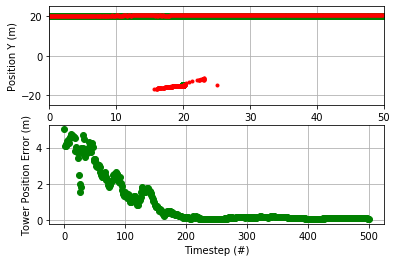

In [191]:
import numpy as np
import scipy.linalg
from copy import deepcopy
from threading import Lock
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
 
 
# Andy's UKF implementation
 
def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    #print("x_in: ", x_in)
    x_out = np.zeros(len(x_in))
    x_out[0] = x_in[0] + timestep * x_in[2] # x position
    x_out[1] = x_in[1] + timestep * x_in[3] # y position
    x_out[2] = x_in[2] # x velocity
    x_out[3] = x_in[3] # y velocity
    #print("x_out: ", x_out)
    return x_out
  
def iterate_t(t_in, timestep, inputs):
  '''this function is based on the x_dot and can be nonlinear as needed'''
  #print("x_in: ", x_in)
  t_out = np.zeros(len(t_in))
  t_out[0] = t_in[0] # x position - towers don't move...
  t_out[1] = t_in[1] # y position
  #print("t_out: ", t_out)
  return t_out
 
 
np.set_printoptions(precision=3)
 
n_x_states = 4
n_t_states = 2
 
# Process Noise
q_x = np.eye(n_x_states) * 0.0025
q_x[0][0] = 0.001
q_x[1][1] = 0.001
 
q_t = np.eye(n_t_states) * 0.001 # towers don't move
 
 
# create measurement noise covariance matrices
r_pos = np.zeros([2, 2])
r_pos[0][0] = 0.03
r_pos[1][1] = 0.03
 
r_vel = np.zeros([2, 2])
r_vel[0][0] = 0.03
r_vel[1][1] = 0.03
 
 
r_range = np.zeros([1, 1])
r_range[0][0] = 0.2
 
r_bearing = np.zeros([1, 1])
r_bearing[0][0] = 0.0002
 
r_range_bearing = np.zeros([2,2])
r_range_bearing[0][0] = 0.2
r_range_bearing[1][1] = 0.0002
 
# pass all the parameters into the UKF!
# number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
x_init = np.zeros(n_x_states)
x_init[0] = 0
x_init[1] = 20
x_init[2] = 1.0
x_init[3] = 0.0 # move at a diagonal
 
t_init = np.zeros(n_t_states)
t_init[0] = 25.0 # place tower 1 at [20,0]
t_init[1] = -15.0
 
P_x = 0.1*np.eye(n_x_states)
P_x[0][0] = 10.0
P_x[1][1] = 10.0
 
P_t = 100.0 * np.eye(n_t_states)
 
agent_estimator = UKF(n_x_states, q_x, x_init, P_x, 0.04, 0.0, 2.0, iterate_x)
tower_estimator = UKF(n_t_states, q_t, t_init, P_t, 0.04, 0.0, 2.0, iterate_t)
 
real_x_states = []
estimated_x_states = []
diff_x_states = []
 
real_t_states = []
estimated_t_states = []
diff_t_states = []
 
 
real_x_state = deepcopy(x_init)
real_t_state = deepcopy(np.array([20, -15]))
 
cur_time = 0.0
last_time = 0.0
dt = 0.1
# read data
 
real_x_states.append(real_x_state)
estimated_x_states.append(agent_estimator.get_state())
diff_x_states.append(real_x_state - agent_estimator.get_state())
real_t_states.append(deepcopy(real_t_state))
estimated_t_states.append(deepcopy(tower_estimator.get_state()))
diff_t_states.append(np.linalg.norm(real_t_state[0:2] - tower_estimator.get_state()[0:2]))
 
 
for i in range(500):
 
    cur_time = cur_time + dt
    d_time = cur_time - last_time
    real_x_state = iterate_x(real_x_state, dt,[])
    real_t_state = iterate_t(real_t_state, dt,[])
 
    # create an array for the data from each sensor
    pos_data = np.array([real_x_state[0], real_x_state[1]]) + 0.3 * np.random.randn(2)
    vel_data = np.array([real_x_state[2], real_x_state[3]]) + 0.03 * np.random.randn(2)
 
    diff = real_x_state[0:2]-real_t_state
    range_data = np.linalg.norm(diff) + 0.5 * np.random.randn(1)
    bearing_data = math.atan2(real_t_state[1] - real_x_state[1], real_t_state[0] - real_x_state[0])
 
    last_time = cur_time
 
    # prediction is pretty simple
    agent_estimator.predict(d_time)
 
    # updating isn't bad either
    # remember that the updated states should be zero-indexed
    # the states should also be in the order of the noise and data matrices
    if i % 50000 == 0:
        agent_estimator.update([0,1], pos_data, r_pos)
    
    agent_estimator.update([2,3], vel_data, r_vel)
 
    tower_estimator.update_range([0,1], r_range, [real_x_state[0],real_x_state[1]], range_data)
    #tower_estimator.update_bearing([0,1], r_bearing, [real_x_state[0],real_x_state[1]], bearing_data)
 
    # print("---",i,"-----------------------------------------------------")
    # print("Real state: ", real_t_state)
    # print("Estimated state: ", tower_estimator.get_state())
    # print("Difference: ", np.linalg.norm(real_t_state[0:2] - tower_estimator.get_state()[0:2]))
 
    real_x_states.append(real_x_state)
    estimated_x_states.append(agent_estimator.get_state())
    diff_x_states.append(real_x_state - agent_estimator.get_state())
    real_t_states.append(deepcopy(real_t_state))
    estimated_t_states.append(deepcopy(tower_estimator.get_state()))
    diff_t_states.append(np.linalg.norm(real_t_state[0:2] - tower_estimator.get_state()[0:2]))
 
 
plt.subplot(2,1,1)
 
plt.plot(np.asarray(real_x_states)[:,0], np.asarray(real_x_states)[:,1],'go')
plt.plot(np.asarray(estimated_x_states)[:,0], np.asarray(estimated_x_states)[:,1],'r.')
plt.plot(np.asarray(real_t_states)[:,0], np.asarray(real_t_states)[:,1],'go')
plt.plot(np.asarray(estimated_t_states)[:,0], np.asarray(estimated_t_states)[:,1],'r.')
 
plt.grid()
plt.xlabel("Position X (m)")
plt.ylabel("Position Y (m)")
plt.axis([0,50,-25,25])
 
plt.subplot(2,1,2)
 
plt.plot(diff_t_states,'go')
 
plt.grid()
plt.xlabel("Timestep (#)")
plt.ylabel("Tower Position Error (m)")
plt.show()
